In [58]:
import matplotlib.pyplot as plt
import numpy as np
import casperfpga
import time
from lwa_f import snap2_fengine
from lwa_f import blocks
#from lwautils import lwa_arx 
import pandas as pd
from cr_functions import *
import struct
import math
from scipy import special as sp
from scipy import optimize as oz
from scipy import stats as st
from lwa_antpos import mapping


# Notebook overview
This notebook runs threshold scans to count trigger and veto rates for one subarray.

NOTE ABOUT THIS VERSION:  Tests on May 28, the first time using delays from calibrator visibilities. RFI environment seems worse, or else gains are different from last time.

## Contents
### Functions to calculate delays
Read delays exported from a calibration table, which was made by running the casa task gaincal on Cygnus A visibilities. Calculate the number of clock cycles of delay to apply to each FPGA channel.
### Load firmware, initialize, and set delays
### Send a snapshot and inspect 
Sometimes I skip this section so note that the snapshot plotted may be old.
### Individual Antenna Threshold Scan
Vary the voltage threshold and count the number of times each antenna exceeds that threshold.
### How often are antennas saturating?
### Single-board threshold scan, no veto
Vary the minimum number of antennas to trigger and the voltage threshold and count the trigger rate.
### Window length scan
Explore the dependence of trigger rate on window length.
### Single-board threshold scan with veto

# Calculate Delays

In [84]:

def delay_dictionary_from_textfile(fname):
    #builds a dictionary of delays where the keys are antenna names in the format "LWA-089A"
    #input is a text file exported from plotms, the delay calibration table is the plotms input and the plotms "yaxis" is delay
    data = pd.read_csv(fname, sep=" ")
    data.columns = ['x', 'y', 'chan', 'scan', 'field', 'ant1', 'ant2', 'ant1name', 'ant2name', 'time', 'freq', 'spw', 'corr', 'offset', 'currchunk', 'irel', 'placeholder']
    delaydictionary={}
    for i in range(1,len(data)):
        delay=data['y'][i]
        longname=str(data['ant1name'][i])
        if data['corr'][i]=='R':
            name="LWA-"+longname[3:6]+'A'
        elif data['corr'][i]=='L':
            name="LWA-"+longname[3:6]+'B'
        delaydictionary[name]=delay
    return delaydictionary

def clock_cycle_delay_array_from_dictionary(delay_dictionary):
    #calculate delays in number of clock cycles to write to each signal stream of each SNAP2
    #input is a dictionary with antenna names as keys (in format "LWA-089A") and values are delay in nanoseconds
    delays_array=np.ones((64,11),dtype=int)  #array to hold delay values for 11 SNAP2s and 64 channels each.
    for name in delay_dictionary.keys():
        delay_ns=float(delay_dictionary[name])
        delay_int=int(delay_ns*1e-9*1.97e8)
        snap2,channel=mapping.antpol_to_fpga(name[:-1], name[-1])
        #print(snap2,channel)
        delays_array[channel,snap2-1]+=delay_int
    most_negative_delay=np.min(delays_array)
    delays_array+=-1*most_negative_delay  #delays to write to block cannot be zero, so they are all relative to the antenna that is most ahead of the reference antenna
    return delays_array

# Load firmware

In [ ]:
#fpgfile="/home/ubuntu/kp/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c_2022-05-12_1406.fpg"
#fpgfile="/home/ubuntu/kp/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg"
fpgfile="/home/ubuntu/kp/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c_2022-04-14_0450.fpg"

brdname='snap07'
#load firmware and initialize etc
brd=snap2_fengine.Snap2Fengine(brdname)
brd.program(fpgfile)


casperbrd = casperfpga.CasperFpga(brdname, transport=casperfpga.TapcpTransport)

2022-05-29 04:32:49,091 - lwa_f.blocks.block:snap07 - INFO - adc - Detected FMC ADC board on port 0
2022-05-29 04:32:49,344 - lwa_f.blocks.block:snap07 - INFO - adc - Detected FMC ADC board on port 1
2022-05-29 04:32:49,356 - lwa_f.snap2_fengine:snap07 - INFO - Loading firmware /home/ubuntu/kp/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c_2022-04-14_0450.fpg to snap07


100% (593 of 593) |######################| Elapsed Time: 0:04:32 Time:  0:04:32


In [44]:
brd.initialize(read_only=False)
brd.sync.arm_sync()
brd.sync.sw_sync()

2022-05-29 01:07:44,536 - lwa_f.snap2_fengine:snap07 - INFO - Initializing block (writable): fpga
2022-05-29 01:07:44,537 - lwa_f.snap2_fengine:snap07 - INFO - Initializing block (writable): adc
2022-05-29 01:07:44,543 - lwa_f.blocks.block:snap07 - INFO - adc - FMC 0 board 0: Setting clock source to 1
2022-05-29 01:07:44,551 - lwa_f.blocks.block:snap07 - INFO - adc - FMC 0 board 1: Setting clock source to 1
2022-05-29 01:07:44,557 - lwa_f.blocks.block:snap07 - INFO - adc - FMC 1 board 0: Setting clock source to 1
2022-05-29 01:07:44,564 - lwa_f.blocks.block:snap07 - INFO - adc - FMC 1 board 1: Setting clock source to 1
2022-05-29 01:07:52,683 - lwa_f.blocks.block:snap07 - INFO - adc - FMC 0 board 0 clock rates: [490864431, 98256424, 98287624, 0, 0]
2022-05-29 01:07:52,684 - lwa_f.blocks.block:snap07 - INFO - adc - FMC 0 board 0: MMCM locked
2022-05-29 01:07:53,693 - lwa_f.blocks.block:snap07 - INFO - adc - FMC 0 board 1 clock rates: [490721695, 98195165, 98274676, 98307890, 0]
2022-05-

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-05-29 01:08:03,996 - lwa_f.blocks.block:snap07 - INFO - adc - FMC 0 data lane delays:
[[368, 360, 368, 352, 352, 344, 352, 344], [304, 296, 288, 288, 288, 288, 280, 296], [312, 304, 312, 304, 304, 304, 304, 320], [344, 352, 344, 336, 336, 336, 344, 336], [296, 296, 296, 296, 296, 296, 296, 296], [272, 272, 288, 272, 272, 264, 272, 264], [304, 288, 288, 296, 296, 304, 288, 288], [328, 320, 328, 320, 320, 336, 328, 328]]
2022-05-29 01:08:03,997 - lwa_f.blocks.block:snap07 - INFO - adc - FMC 0 data lane slacks:
[[40, 40, 48, 48, 40, 40, 40, 40], [40, 40, 40, 48, 32, 40, 40, 40], [40, 40, 40, 40, 32, 32, 40, 40], [40, 40, 40, 40, 40, 32, 40, 32], [40, 40, 40, 32, 40, 40, 40, 40], [40, 40, 40, 40, 48, 40, 48, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 32, 40, 32, 40, 40, 32, 40]]
2022-05-29 01:08:03,998 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXX
2022-05-29 01:08:03,999 - lwa_f.blocks.block:snap07 - INF

2022-05-29 01:08:04,031 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXX
2022-05-29 01:08:04,031 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXX
2022-05-29 01:08:04,032 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXX
2022-05-29 01:08:04,032 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXX
2022-05-29 01:08:04,033 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXX
2022-05-29 01:08:04,034 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXX
2022-05-29 01:08:04,034 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-05-29 01:08:13,903 - lwa_f.blocks.block:snap07 - INFO - adc - FMC 1 data lane delays:
[[400, 400, 400, 408, 392, 400, 392, 408], [368, 368, 360, 368, 360, 376, 368, 360], [296, 288, 296, 304, 288, 304, 296, 288], [312, 328, 312, 312, 312, 320, 312, 312], [304, 304, 304, 320, 312, 312, 304, 304], [272, 272, 280, 272, 280, 272, 280, 272], [288, 272, 272, 288, 272, 272, 272, 272], [312, 312, 312, 312, 312, 312, 320, 312]]
2022-05-29 01:08:13,903 - lwa_f.blocks.block:snap07 - INFO - adc - FMC 1 data lane slacks:
[[40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 32, 32, 32, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [48, 40, 40, 48, 40, 40, 40, 40], [40, 40, 40, 40, 40, 32, 40, 32], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40]]
2022-05-29 01:08:13,904 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXX
2022-05-29 01:08:13,905 - lwa_f.blocks.block:snap07 - INF

2022-05-29 01:08:13,937 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXX
2022-05-29 01:08:13,937 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXX
2022-05-29 01:08:13,938 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXX
2022-05-29 01:08:13,938 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXX
2022-05-29 01:08:13,939 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXX
2022-05-29 01:08:13,940 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXX
2022-05-29 01:08:13,940 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

### Set delays

In [86]:
#calculate delays
delaytextfile='/home/ubuntu/kp/delays/20220420_184251_57MHz.delays.txt'
delay_dictionary=delay_dictionary_from_textfile(delaytextfile)
delays_array=clock_cycle_delay_array_from_dictionary(delay_dictionary)

#set delays
delayblock=blocks.delay.Delay(casperbrd, 'delay', n_streams=64, logger=None)
delayblock.initialize()
snap2index=6 #this is board 7 if it starts with 1, so 0-index means it's 6
for i in range(64):
    z=delays_array[i,6]
    delayblock.set_delay(i,z)




# Send snapshot

In [87]:
#prepare to send a snapshot
setup_data_source(casperbrd,"adc")
setup_ethernet(brdname,casperbrd,fpgfile,'lwacr',100)
setvalue(casperbrd,'brd_id','cr_registers.xlsx',7)

#enable ethernet
setvalue(casperbrd,'eth_enable','cr_registers.xlsx',1)
#send trigger
software_trigger(casperbrd,1)

getvalue(casperbrd,"count_triggers","cr_registers.xlsx")
#reset the trigger counter

Data source set to adc
------------------------
snap07:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:07:07:07
Gateway:  0.0.0.1
IP:  10.41.0.207
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips: []
ARP Table: 
IP: 10.41.0. 58: MAC: 04:3F:72:DF:C2:F8
Setting wait between packets to 100
Packetizer formed 64 packets
Board successfully returned to listening state after readout
Readout took 22848 clock cycles
Packetizer never overflowed
Ethernet block almost-full counter incremented by 0


2

In [89]:
#some debugging
print(getvalue(casperbrd,'dest_ip','cr_registers.xlsx'))
print(getvalue(casperbrd,'eth_enable','cr_registers.xlsx'))
print(getvalue(casperbrd,'cr_dest_port','cr_registers.xlsx'))
print(getvalue(casperbrd,'forty_g_up','cr_registers.xlsx'))
print(getvalue(casperbrd,'forty_g_tx','cr_registers.xlsx'))
print(getvalue(casperbrd,'brd_id','cr_registers.xlsx'))

170459194
1
11111
1
0
7


I set the data source to constant and then sent a snapshot, from which I construct the mapping to look up what digital input corresponds to a given channel index in my snapshots. This does not need to be repeated, since I saved the mapping file.

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
  36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
  54. 55. 56. 57. 58. 59. 60. 61. 62. 63.]
 [15. 14. 13. 12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.  1.  0. 31. 30.
  29. 28. 27. 26. 25. 24. 23. 22. 21. 20. 19. 18. 17. 16. 47. 46. 45. 44.
  43. 42. 41. 40. 39. 38. 37. 36. 35. 34. 33. 32. 63. 62. 61. 60. 59. 58.
  57. 56. 55. 54. 53. 52. 51. 50. 49. 48.]]


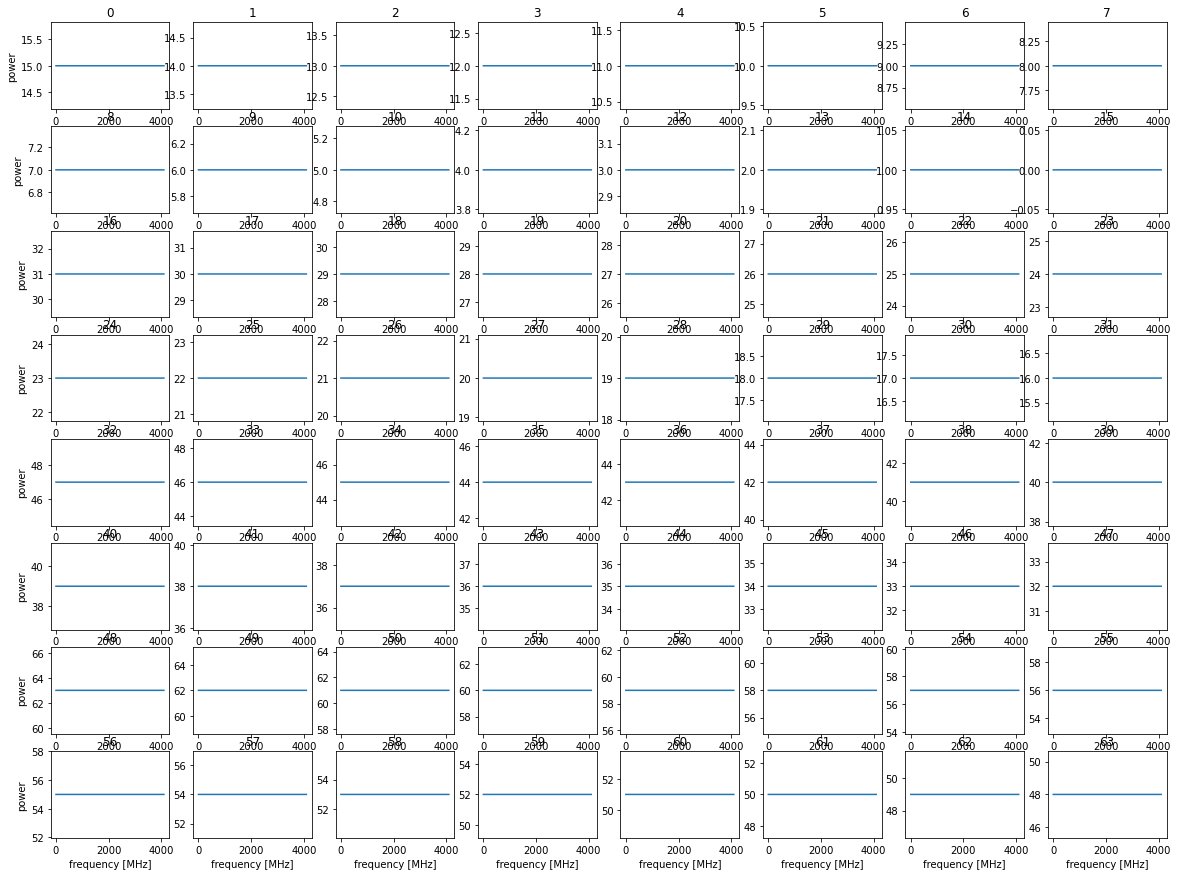

In [90]:
snapshotfname='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/channel-mapping-snapshot.npy'
snapshot=np.load(snapshotfname)
plt.figure(figsize=(20,15))
channelmap=np.zeros((2,64))

for i in range(64):
    channelmap[0,i]=i
    channelmap[1,i]=snapshot[0,i+4]
    plt.subplot(8,8,1+i)
    plt.title(i)
    plt.plot(snapshot[:,i+4])
    if i > 55:
        plt.xlabel('frequency [MHz]')
    if i%8==0:
        plt.ylabel('power')
print(channelmap)
#np.savetxt("channelmap.txt",channelmap)

In [103]:
chanmap=np.loadtxt('channelmap.txt')
#each entry is cosmic ray output index, then FPGA input index
print(chanmap[1,:])
print(mapping.antpol_to_fpga('LWA-355', 'A'))

[15. 14. 13. 12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.  1.  0. 31. 30.
 29. 28. 27. 26. 25. 24. 23. 22. 21. 20. 19. 18. 17. 16. 47. 46. 45. 44.
 43. 42. 41. 40. 39. 38. 37. 36. 35. 34. 33. 32. 63. 62. 61. 60. 59. 58.
 57. 56. 55. 54. 53. 52. 51. 50. 49. 48.]
(7, 60)


 I sent a snapshot of real adc data and here I plot how it looks

In [92]:
snapshotfname='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/single_board_snapshot1653788402.6429825_0_0.npy'

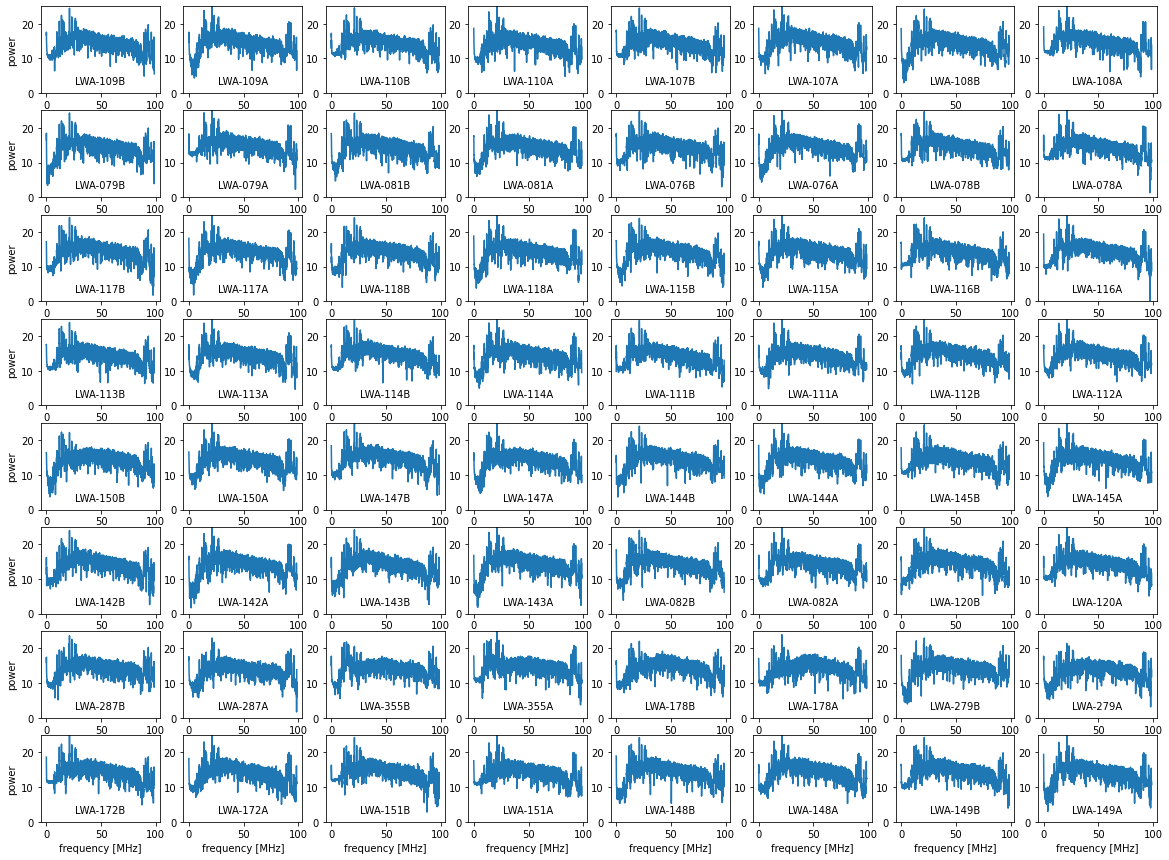

In [93]:
snapshot=np.load(snapshotfname)

#plot spectra
fbins=np.linspace(0,197/2,int(1+4096/2))

fig= plt.figure(figsize=(20,15))
for i in range(64):
    ax=fig.add_subplot(8,8,1+i)
    fpgachan=chanmap[1,i]
    antname=mapping.snap2_to_antpol(7,fpgachan)
    ax.text(.5,.1,antname,horizontalalignment='center',transform=ax.transAxes)

    spec=np.fft.rfft(snapshot[:,i+4])
    plt.plot(fbins,np.log(np.square(np.abs(spec))))
    plt.ylim(0,25)
    if i > 55:
        plt.xlabel('frequency [MHz]')
    if i%8==0:
        plt.ylabel('power')

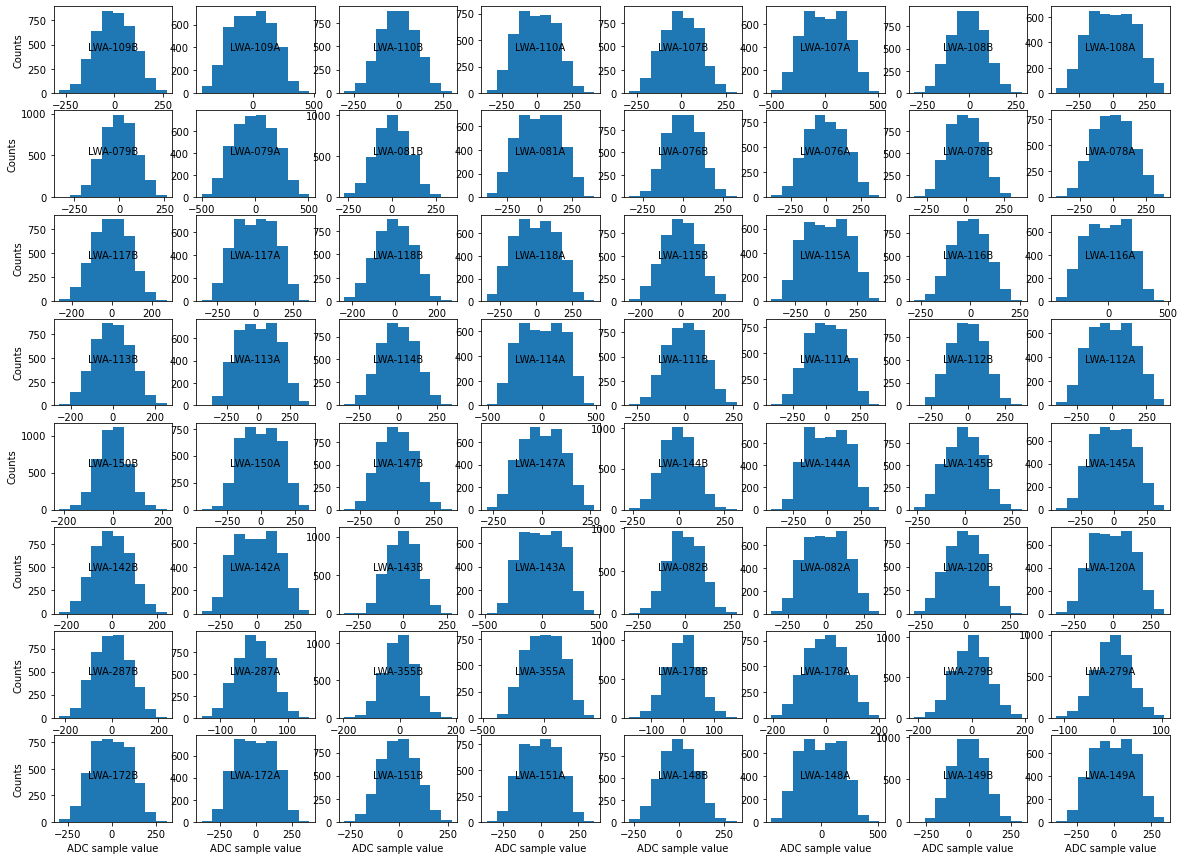

In [96]:
fbins=np.linspace(0,197/2,int(1+4096/2))
isnormal=np.zeros(64)

fig= plt.figure(figsize=(20,15))
for i in range(64):
    ax=fig.add_subplot(8,8,1+i)
    #ax.text(.5,.5,int(chanmap[1,i]),horizontalalignment='center',transform=ax.transAxes)
    fpgachan=chanmap[1,i]
    antname=mapping.snap2_to_antpol(7,fpgachan)
    ax.text(.5,.5,antname,horizontalalignment='center',transform=ax.transAxes)
        

    plt.hist(snapshot[:,i+4])
    isnormal[i] = st.normaltest(snapshot[:,i+4])[1]
    if i > 55:
        plt.xlabel('ADC sample value')
    if i%8==0:
        plt.ylabel('Counts')
    #plt.xlim(-200,200)

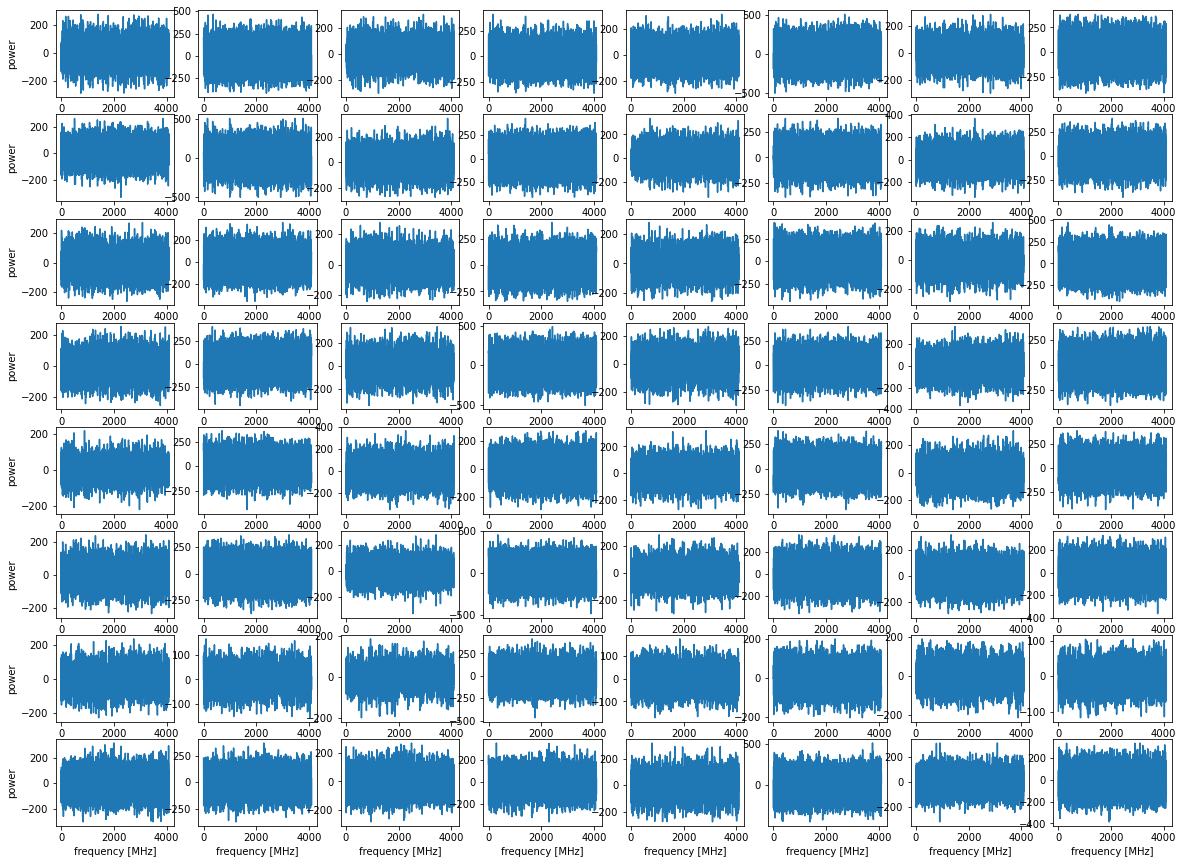

In [97]:
plt.figure(figsize=(20,15))
for i in range(64):
    plt.subplot(8,8,1+i)
    #plt.title(i)
    plt.plot(snapshot[:,i+4])
    fpgachan=chanmap[1,i]
    antname=mapping.snap2_to_antpol(7,fpgachan)
    ax.text(.5,.5,antname,horizontalalignment='center',transform=ax.transAxes)
    if i > 55:
        plt.xlabel('frequency [MHz]')
    if i%8==0:
        plt.ylabel('power')

# Individual antenna threshold scan

In [98]:
setup_data_source(casperbrd,"adc")
thresholds = 4*np.asarray(range(128))
vthresholds = np.flip(thresholds)
results_core = np.zeros((64,128))
results_veto = np.zeros((64,128))

for i in range(len(thresholds)):
    t_c = thresholds[i]
    t_v = vthresholds[i]
    setvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(t_c**2))
    setvalue(casperbrd,"veto_power_thresh","cr_registers.xlsx",int(t_v**2))
    time.sleep(2.75)  #have to wait for it to update
    core,veto = read_threshold_rates(casperbrd)
    results_core[:,i] = core
    results_veto[:,i] = veto

Data source set to adc


0
Fit Core
[77.15361466]
[[13.40484787]]
Fit Veto
[91.93720539]
[[7.85773004]]


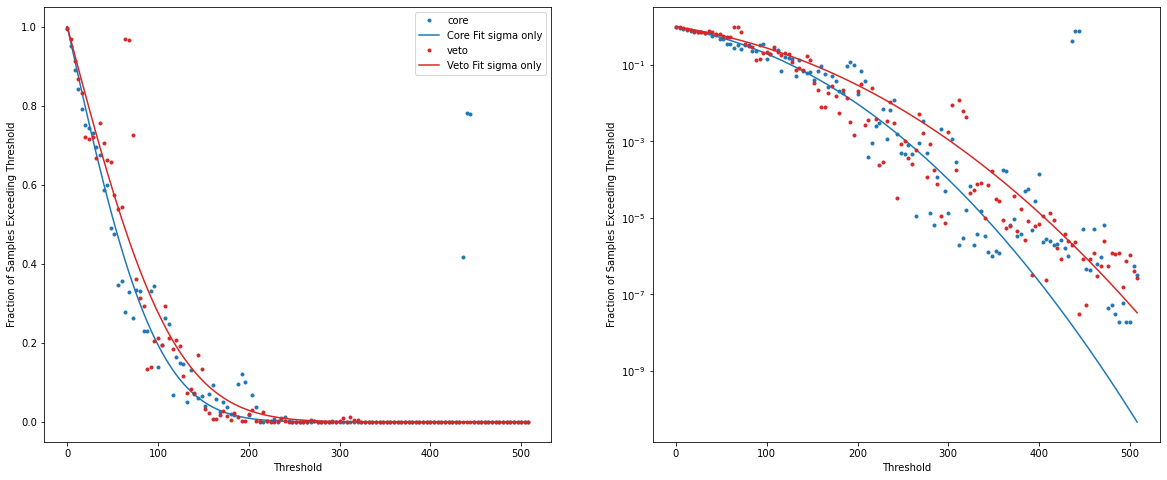

1
Fit Core
[82.64157533]
[[1.34006102]]
Fit Veto
[90.0912893]
[[1.89471307]]


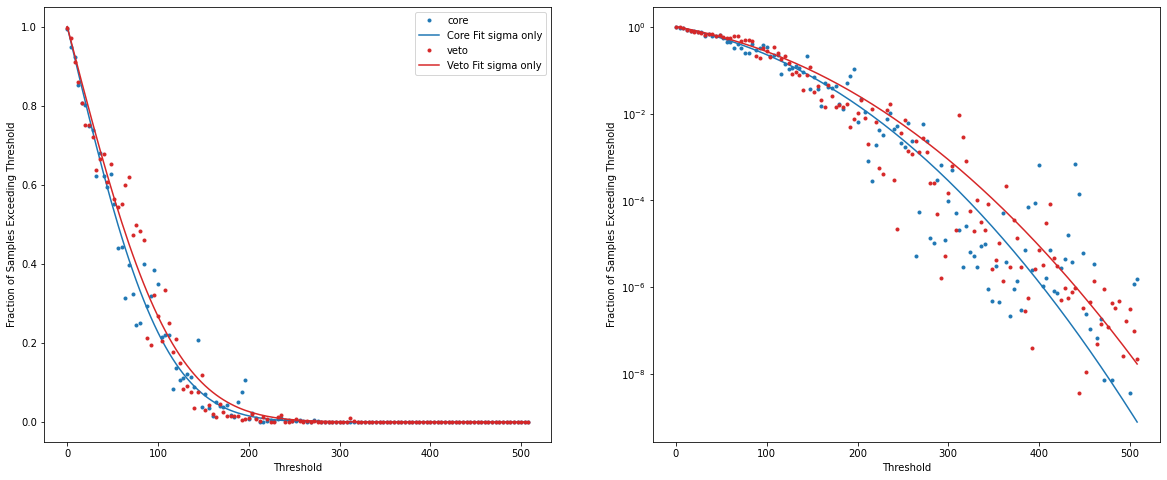

2
Fit Core
[80.52430488]
[[15.63733777]]
Fit Veto
[92.13615445]
[[8.18975417]]


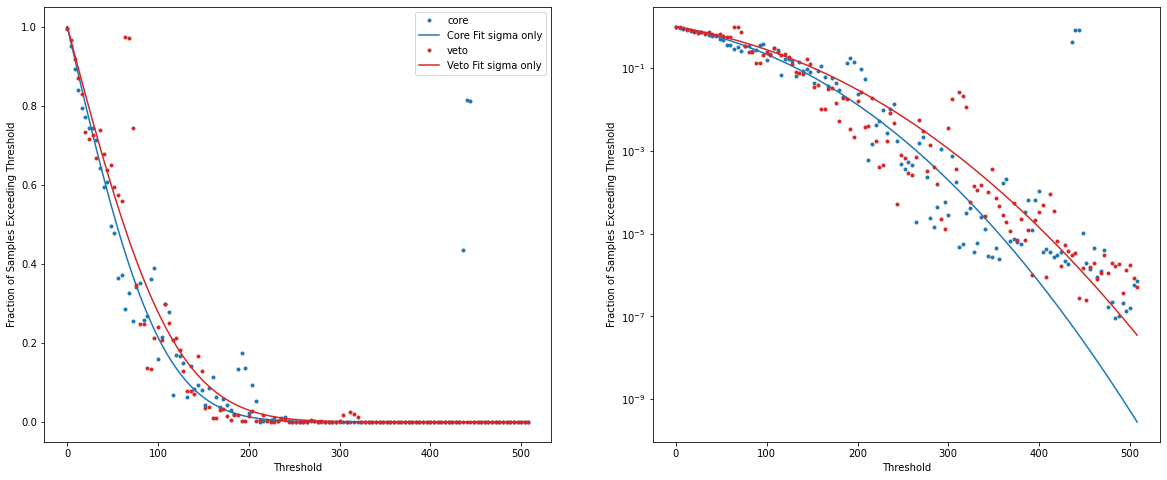

3
Fit Core
[88.91087362]
[[2.35139308]]
Fit Veto
[95.69393336]
[[2.52165424]]


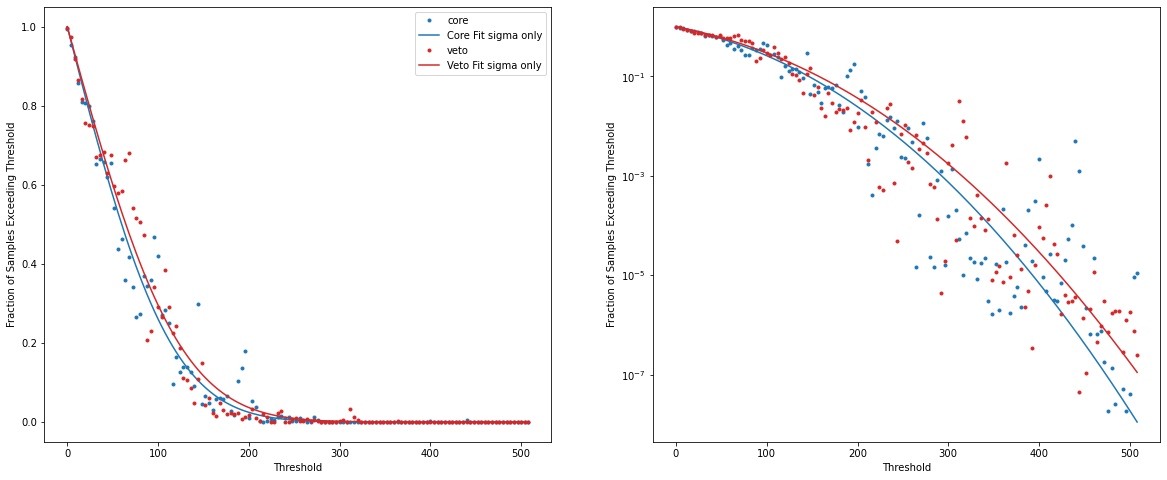

4
Fit Core
[78.29073562]
[[11.83294816]]
Fit Veto
[92.74837256]
[[7.64955299]]


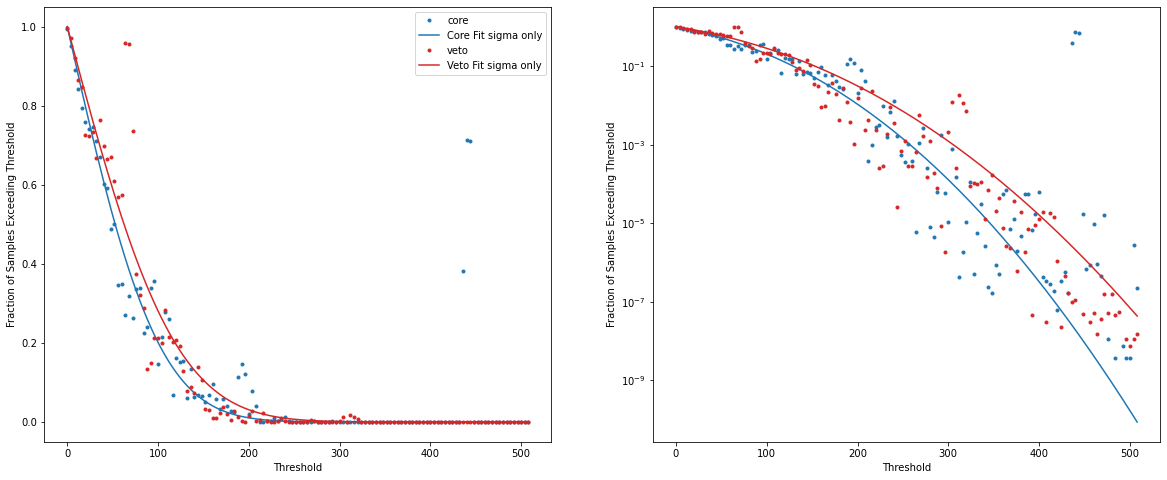

5
Fit Core
[84.72652839]
[[1.44956537]]
Fit Veto
[93.60894038]
[[3.41726809]]


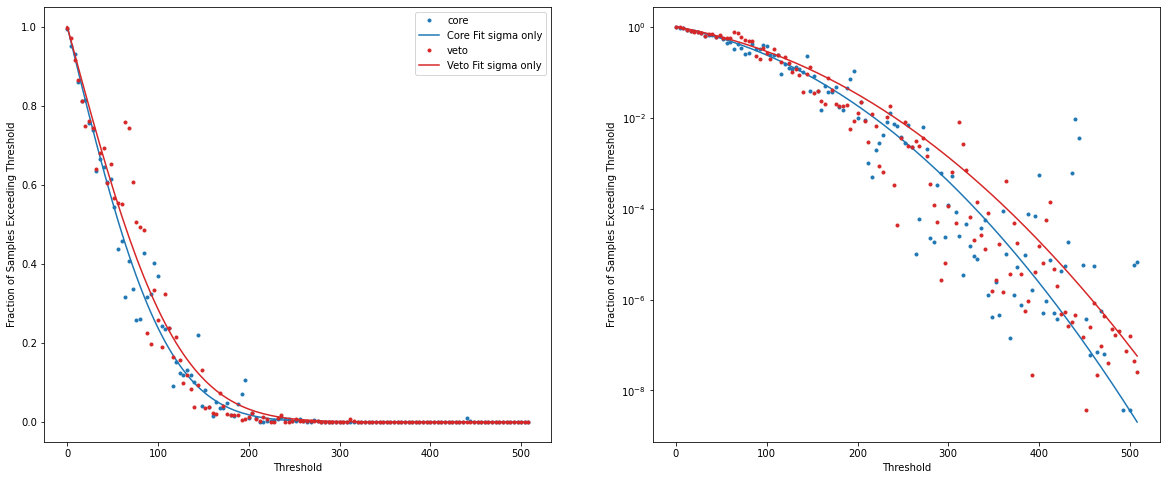

6
Fit Core
[99.19733457]
[[19.10997181]]
Fit Veto
[108.05725397]
[[7.68384263]]


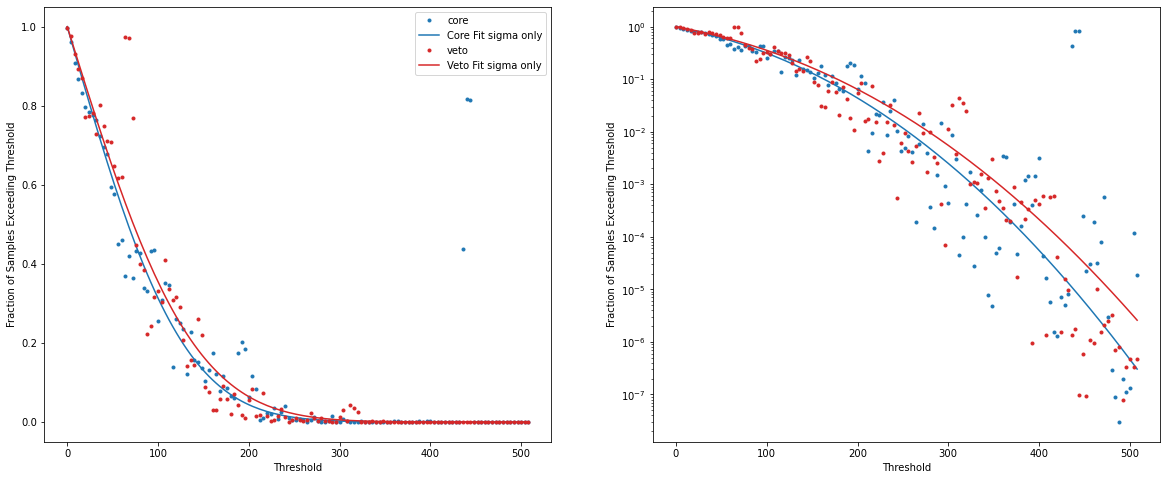

7
Fit Core
[74.06288266]
[[1.18469113]]
Fit Veto
[83.9540265]
[[2.30703494]]


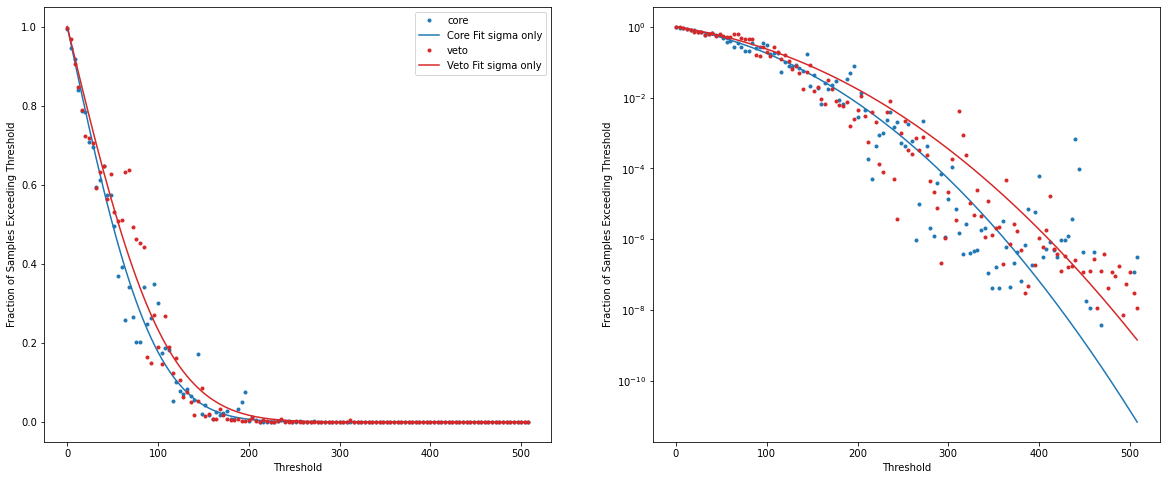

8
Fit Core
[100.68136745]
[[20.01149229]]
Fit Veto
[107.40336569]
[[7.97662744]]


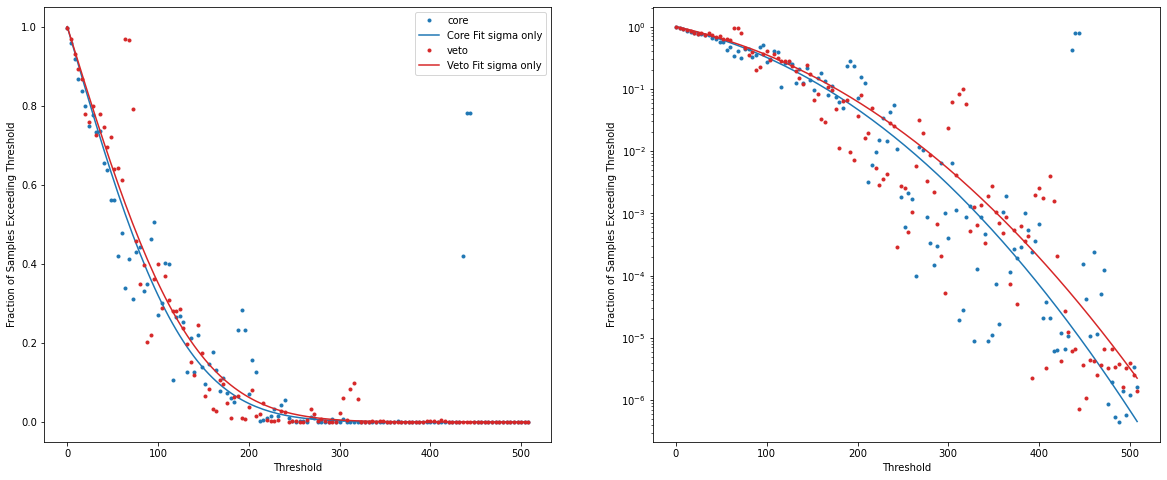

9
Fit Core
[84.02568726]
[[1.89607708]]
Fit Veto
[92.06109268]
[[3.02428199]]


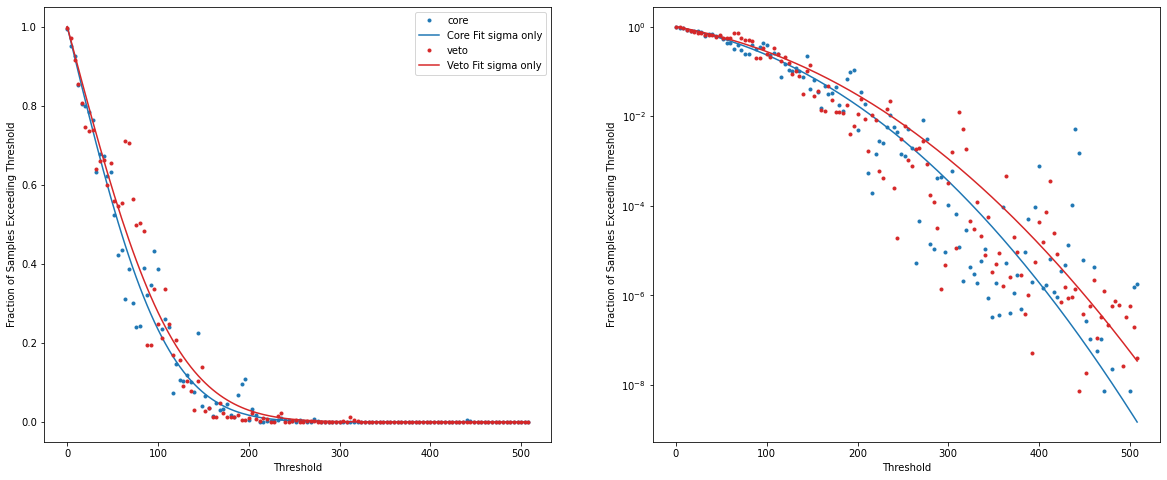

10
Fit Core
[90.73370157]
[[17.59930271]]
Fit Veto
[102.71787563]
[[8.37209652]]


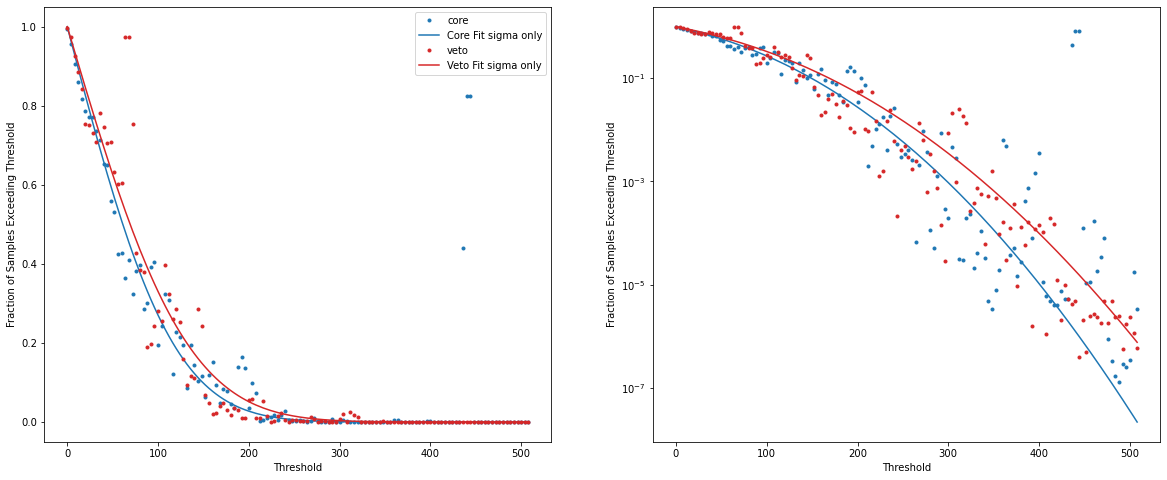

11
Fit Core
[86.2922203]
[[2.36621007]]
Fit Veto
[93.84229972]
[[2.25728382]]


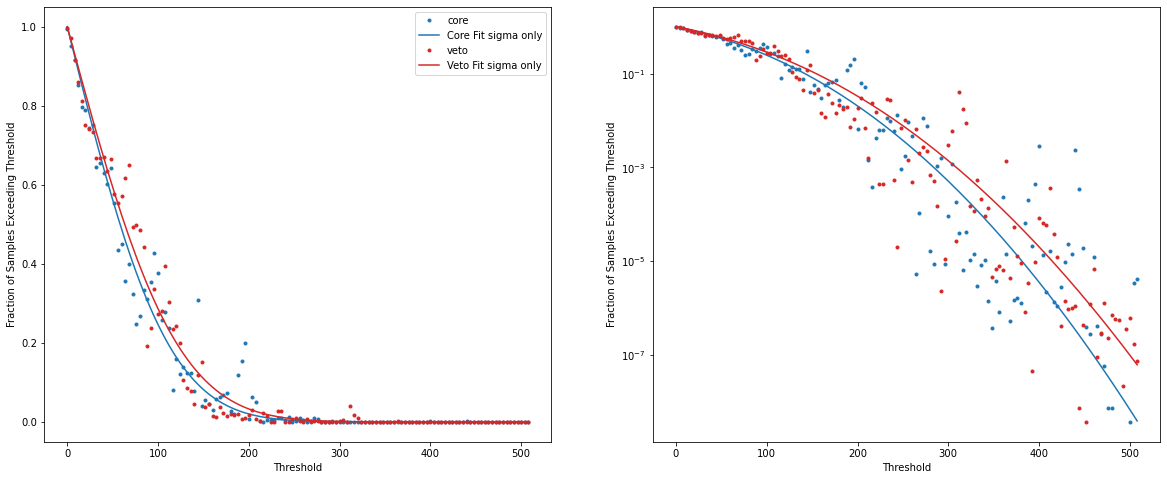

12
Fit Core
[67.09878994]
[[10.67621016]]
Fit Veto
[85.54619382]
[[8.2003653]]


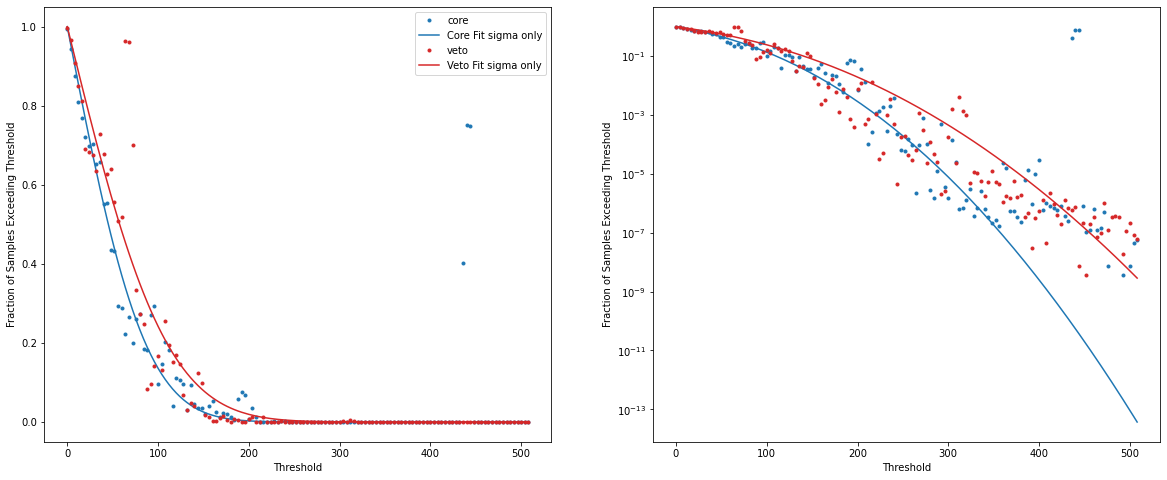

13
Fit Core
[77.57745255]
[[1.38544612]]
Fit Veto
[88.65858084]
[[3.55370876]]


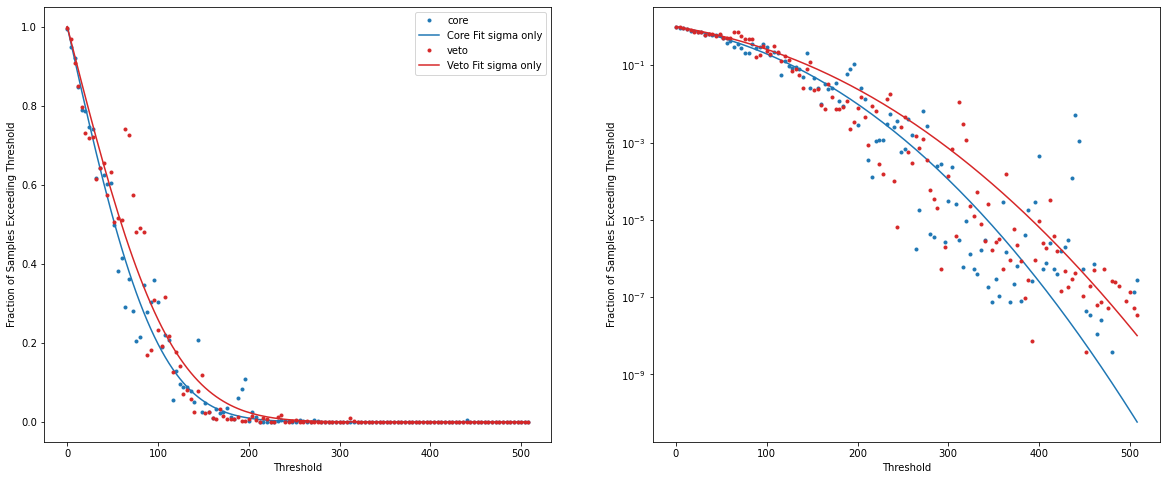

14
Fit Core
[80.62623814]
[[14.33281851]]
Fit Veto
[94.817602]
[[8.06797204]]


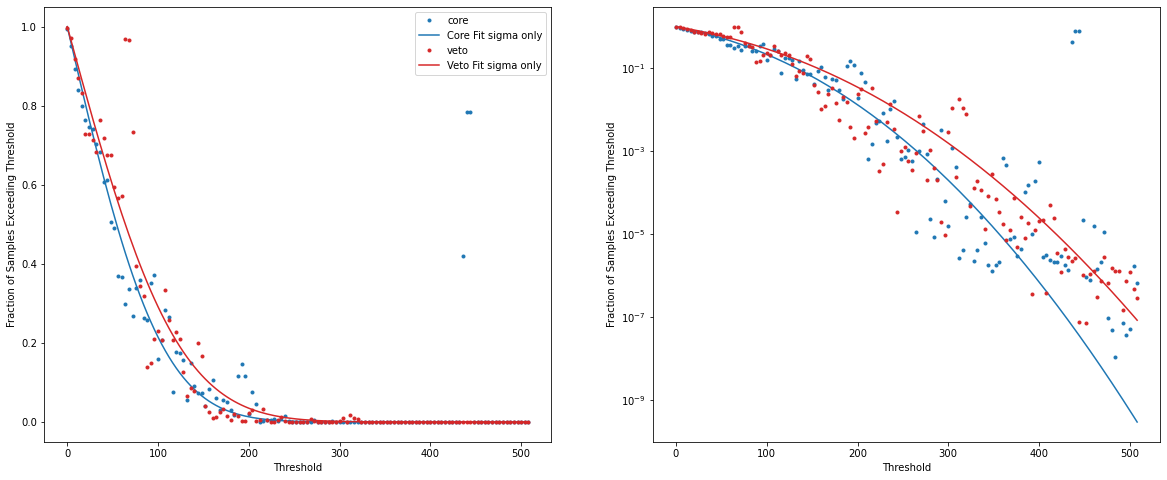

15
Fit Core
[80.46827814]
[[1.41678474]]
Fit Veto
[90.91769056]
[[2.85699641]]


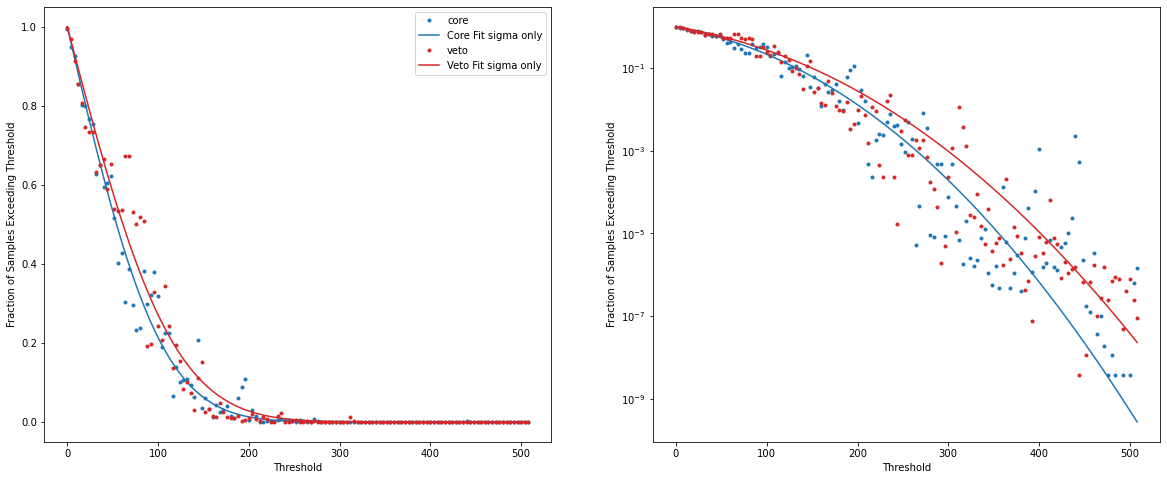

16
Fit Core
[77.87146921]
[[12.30151315]]
Fit Veto
[92.38940142]
[[7.72842722]]


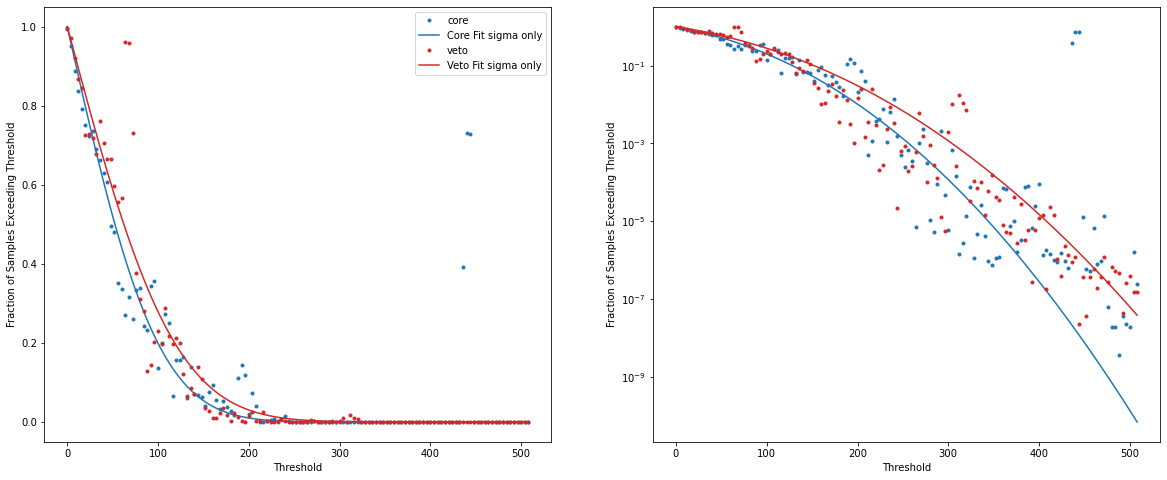

17
Fit Core
[89.59718463]
[[1.71646156]]
Fit Veto
[97.09903705]
[[2.87319357]]


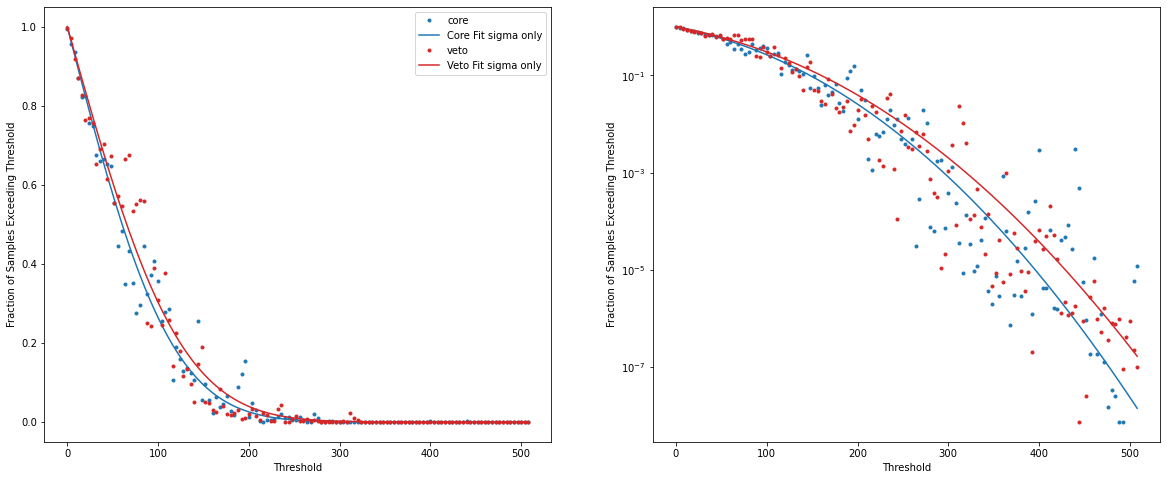

18
Fit Core
[72.1901199]
[[11.92426106]]
Fit Veto
[88.48800174]
[[8.10439225]]


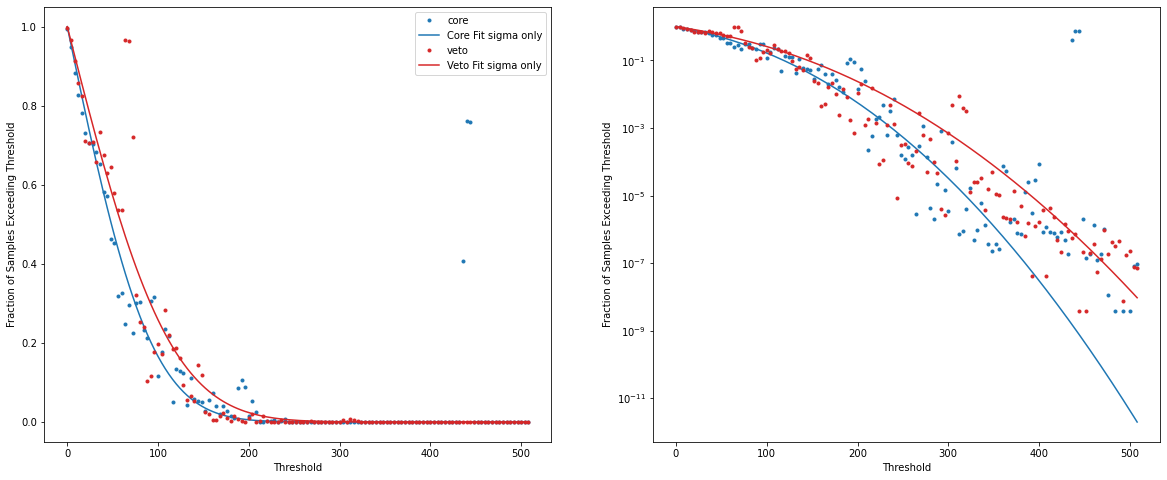

19
Fit Core
[77.82848464]
[[1.55965056]]
Fit Veto
[88.51329448]
[[3.66448752]]


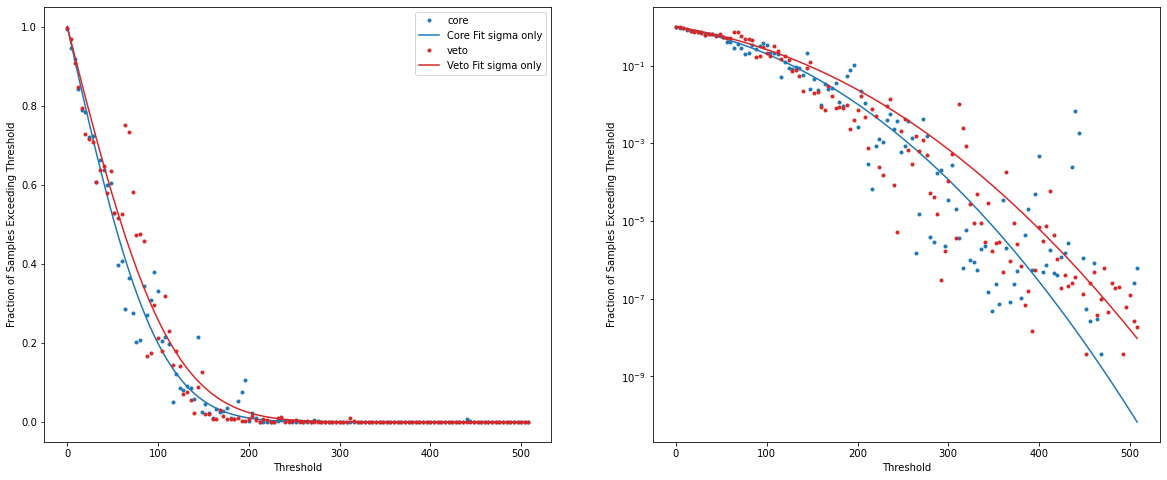

20
Fit Core
[82.94498535]
[[13.62777119]]
Fit Veto
[97.24718263]
[[7.85959427]]


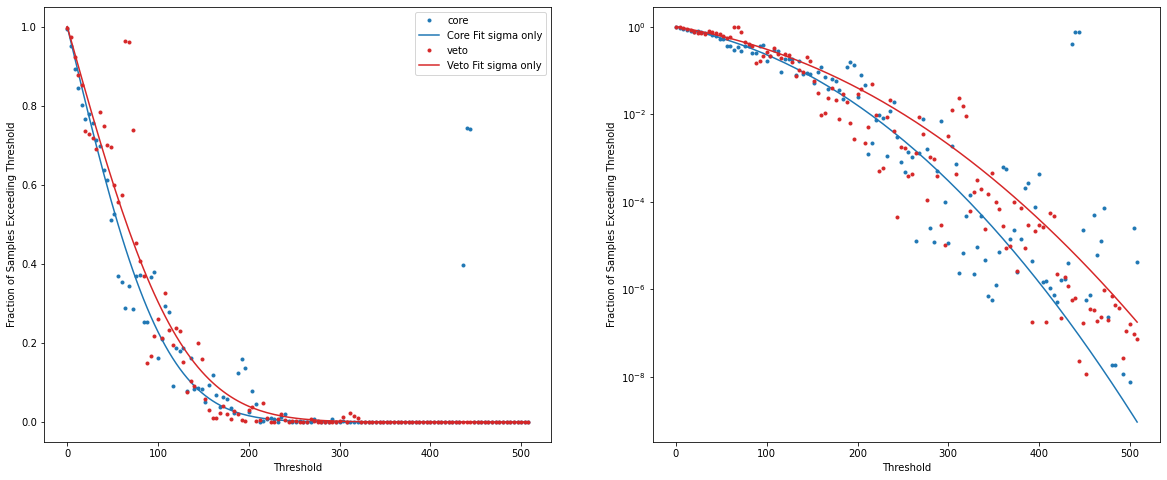

21
Fit Core
[92.23223936]
[[1.44315587]]
Fit Veto
[98.51267062]
[[2.54009803]]


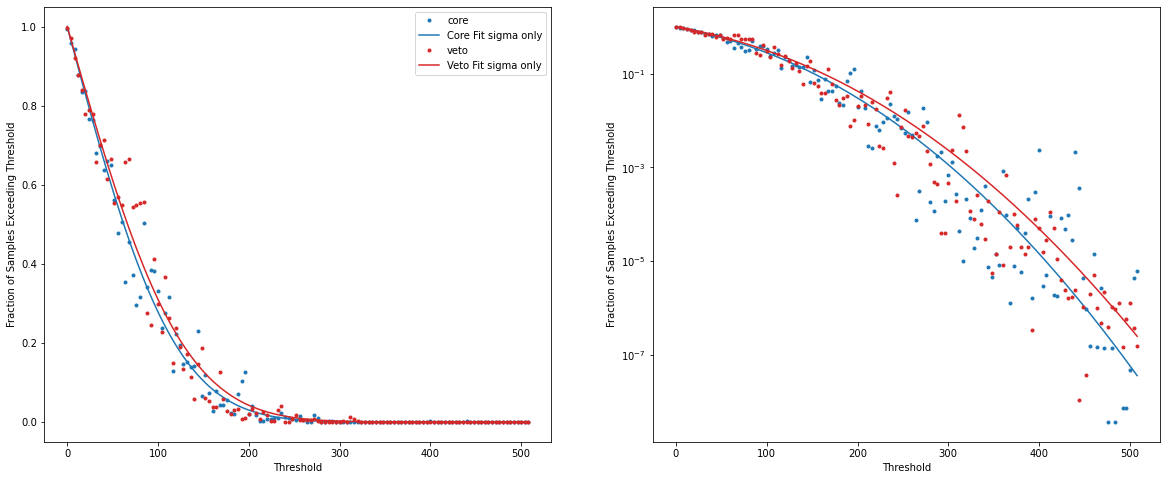

22
Fit Core
[73.1330457]
[[10.60453528]]
Fit Veto
[88.08277204]
[[7.53894082]]


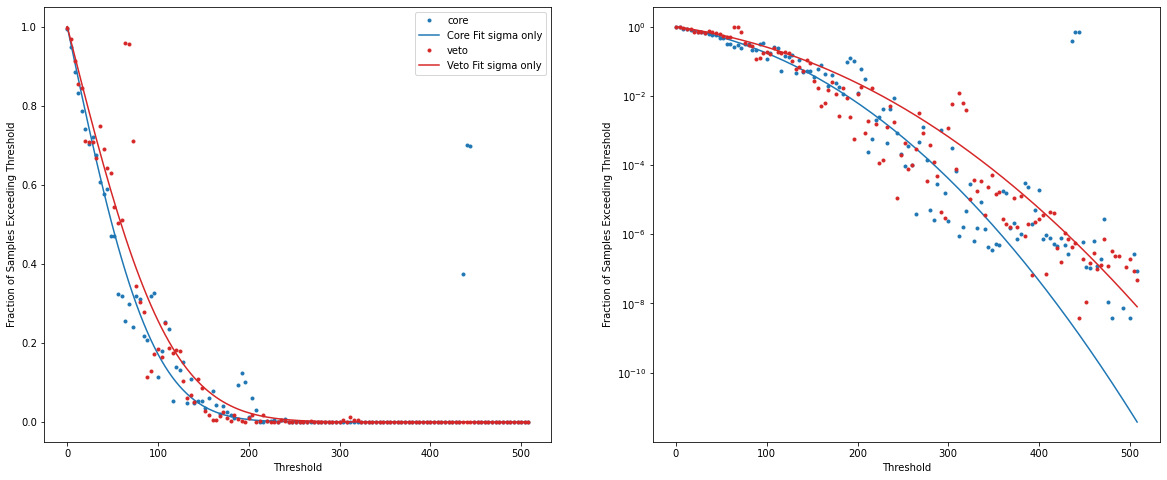

23
Fit Core
[73.14875381]
[[0.9128122]]
Fit Veto
[83.90792236]
[[3.27279954]]


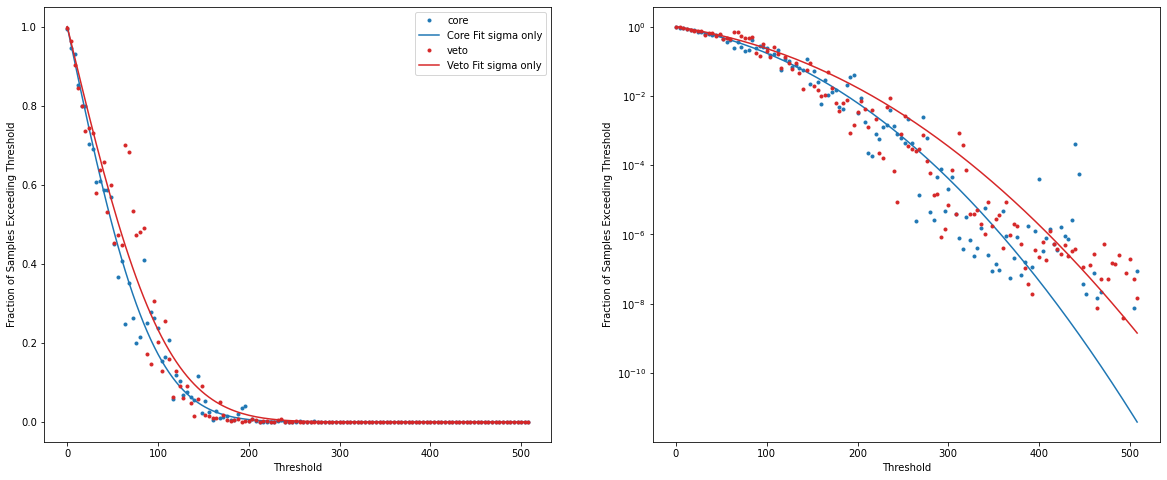

24
Fit Core
[78.97937982]
[[12.53535966]]
Fit Veto
[93.29502365]
[[8.07779933]]


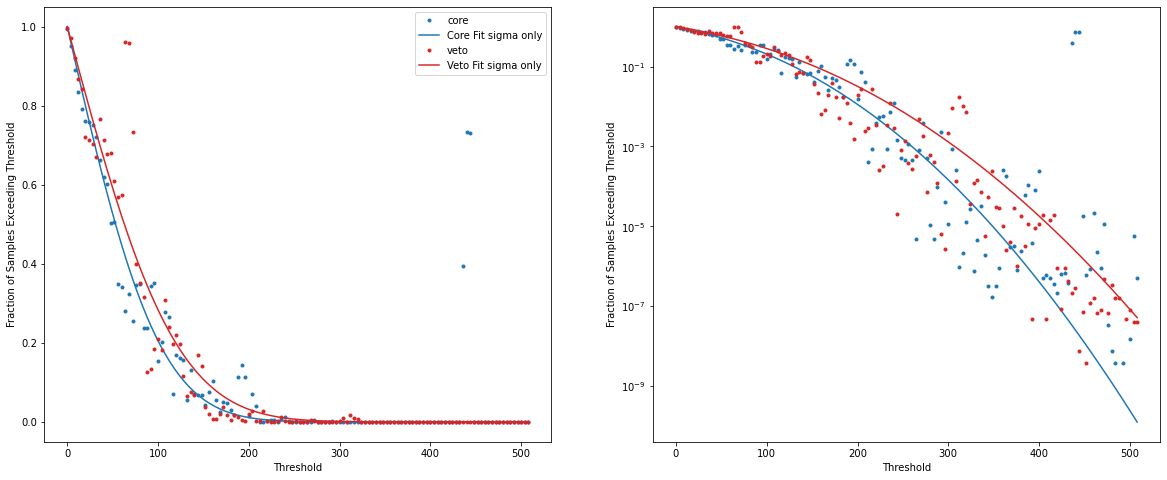

25
Fit Core
[70.11645247]
[[0.88813443]]
Fit Veto
[80.02901044]
[[2.04807419]]


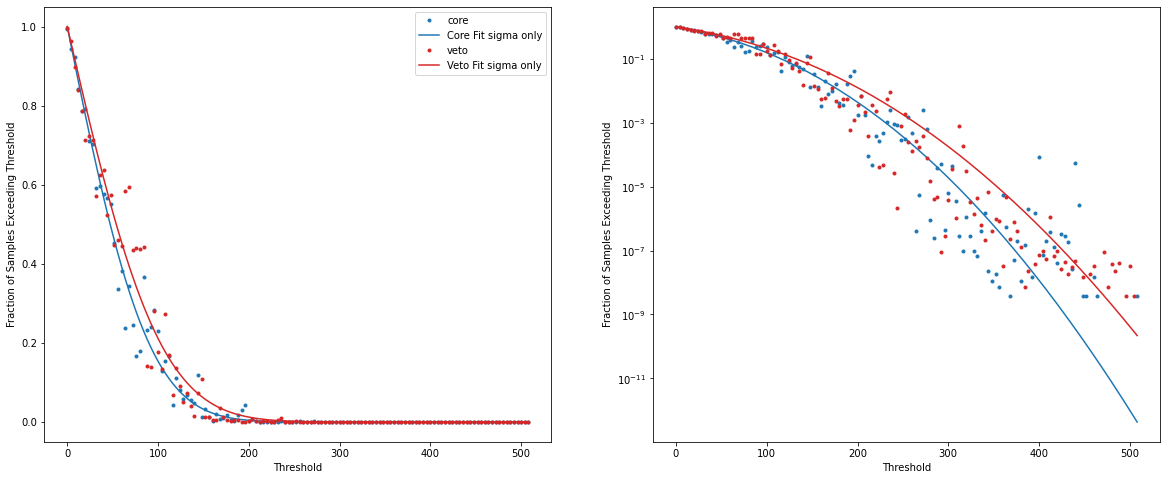

26
Fit Core
[73.75638613]
[[10.62252032]]
Fit Veto
[90.74857971]
[[7.86694479]]


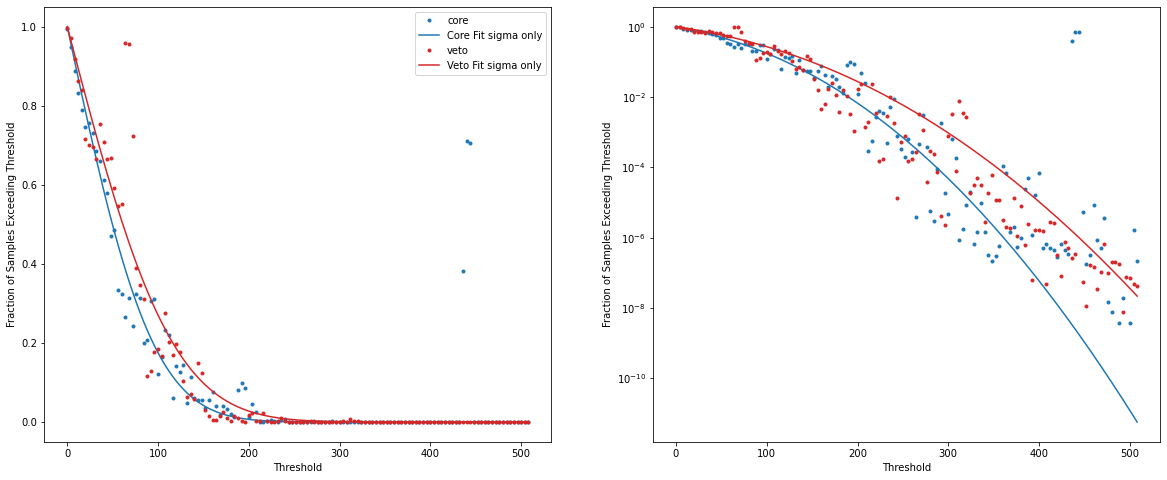

27
Fit Core
[73.66897886]
[[0.83518312]]
Fit Veto
[84.87049627]
[[2.77919813]]


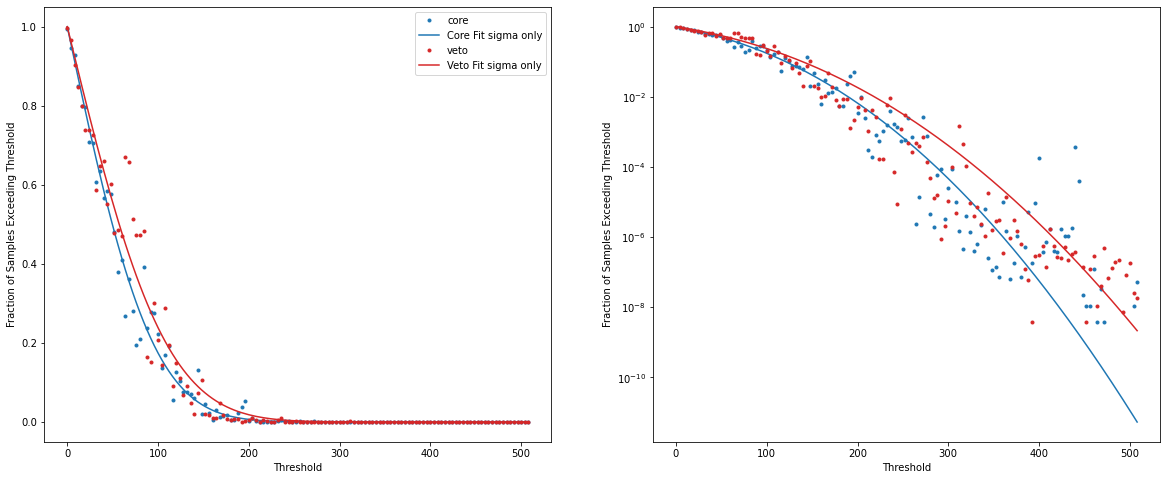

28
Fit Core
[71.36917864]
[[9.96910552]]
Fit Veto
[87.80242873]
[[8.00167441]]


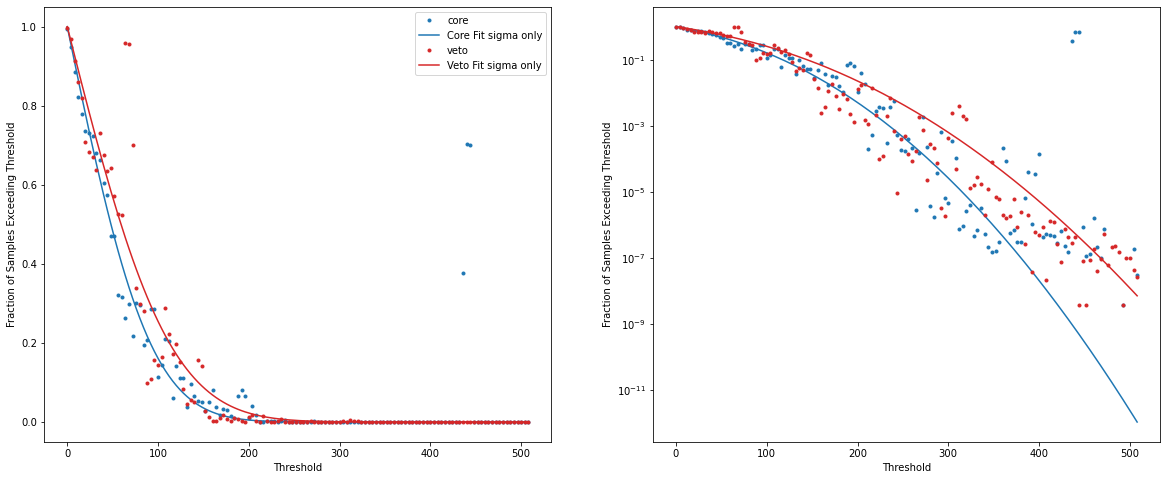

29
Fit Core
[66.73562636]
[[0.88271218]]
Fit Veto
[80.26143644]
[[3.03737599]]


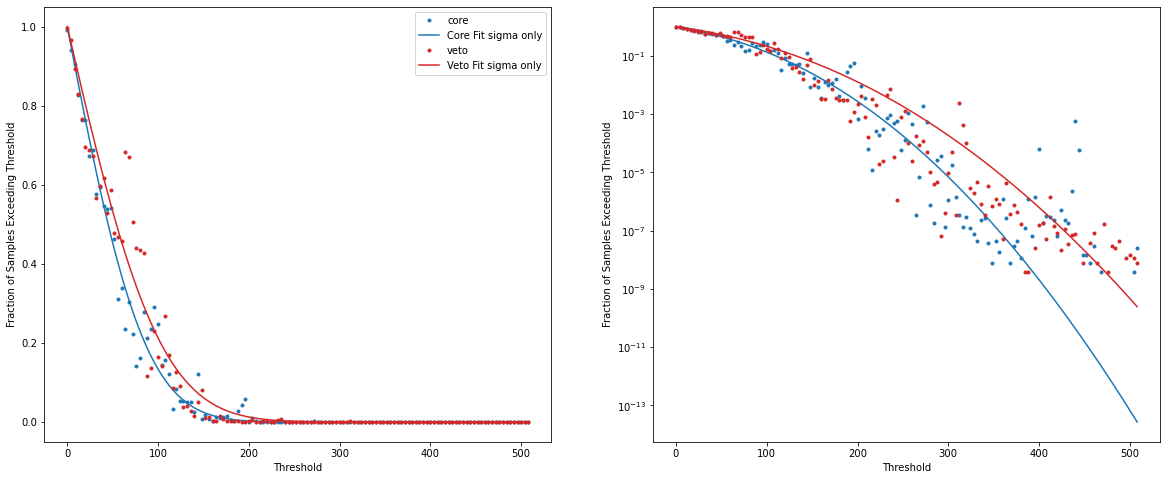

30
Fit Core
[62.6893463]
[[8.10182784]]
Fit Veto
[80.16268302]
[[8.10257376]]


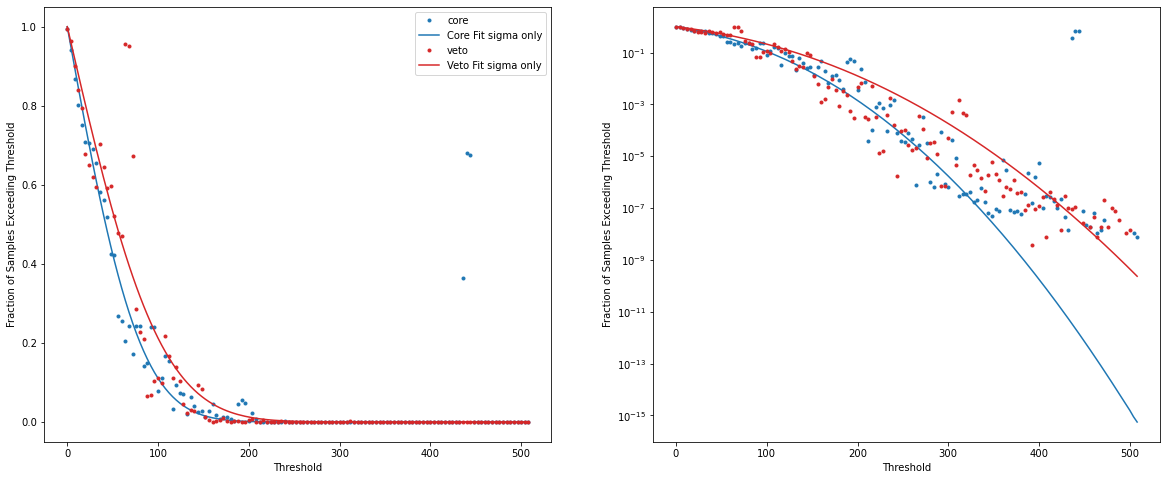

31
Fit Core
[71.86764231]
[[0.88862357]]
Fit Veto
[83.35809182]
[[2.23542871]]


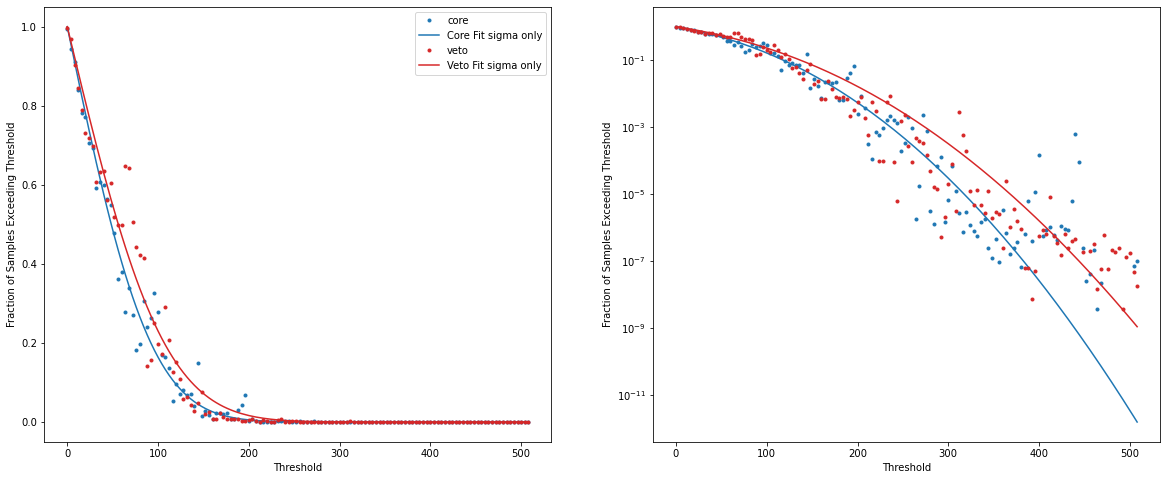

32
Fit Core
[65.95652074]
[[10.42275538]]
Fit Veto
[82.72124652]
[[8.46246892]]


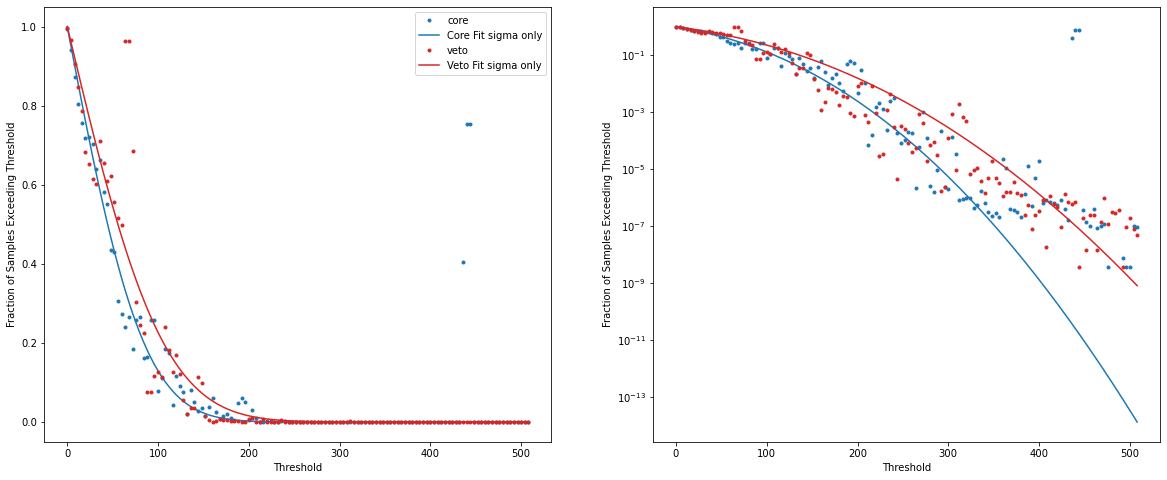

33
Fit Core
[79.60114405]
[[1.52810364]]
Fit Veto
[89.73514494]
[[2.12758758]]


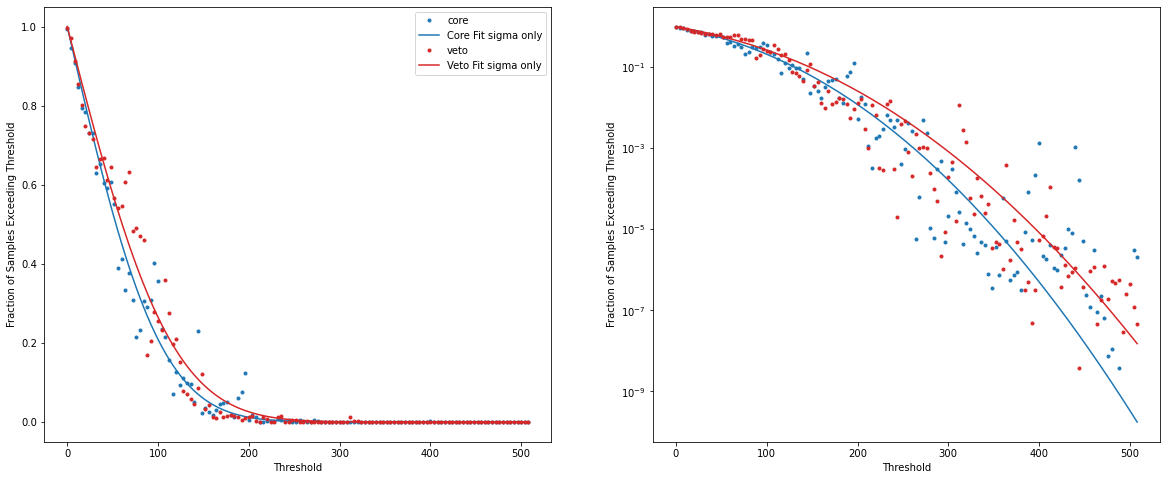

34
Fit Core
[61.73153766]
[[8.11757665]]
Fit Veto
[82.2285587]
[[7.87046787]]


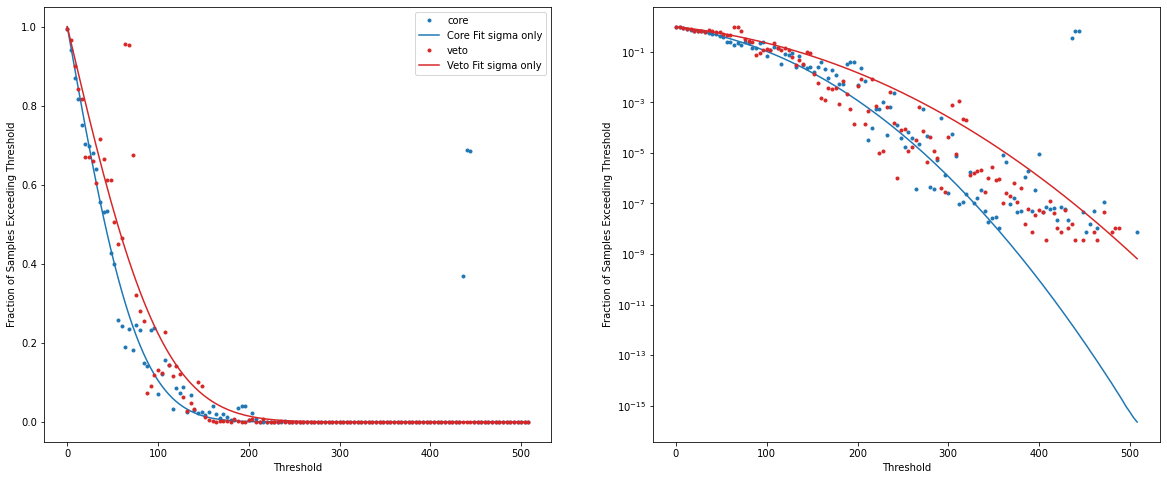

35
Fit Core
[78.13710119]
[[1.24540699]]
Fit Veto
[89.05225774]
[[3.5006439]]


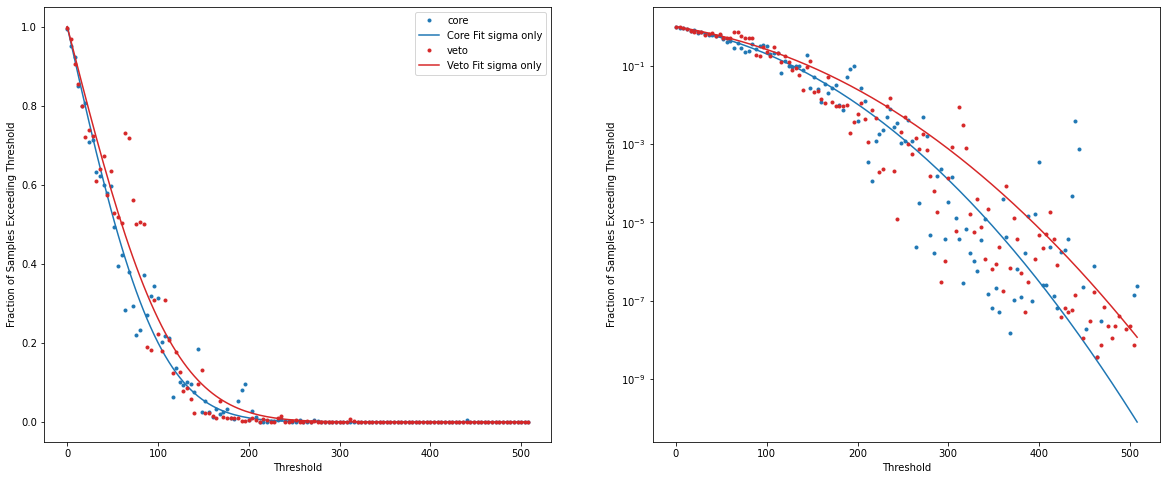

36
Fit Core
[75.9737463]
[[13.72696149]]
Fit Veto
[90.76660684]
[[8.52111701]]


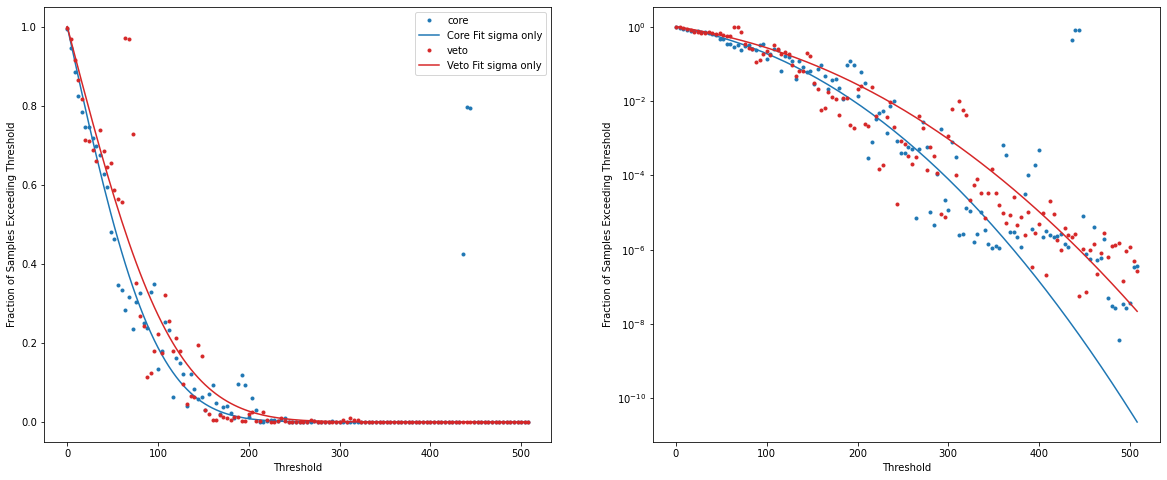

37
Fit Core
[72.31639002]
[[1.84123451]]
Fit Veto
[85.18278482]
[[3.2379536]]


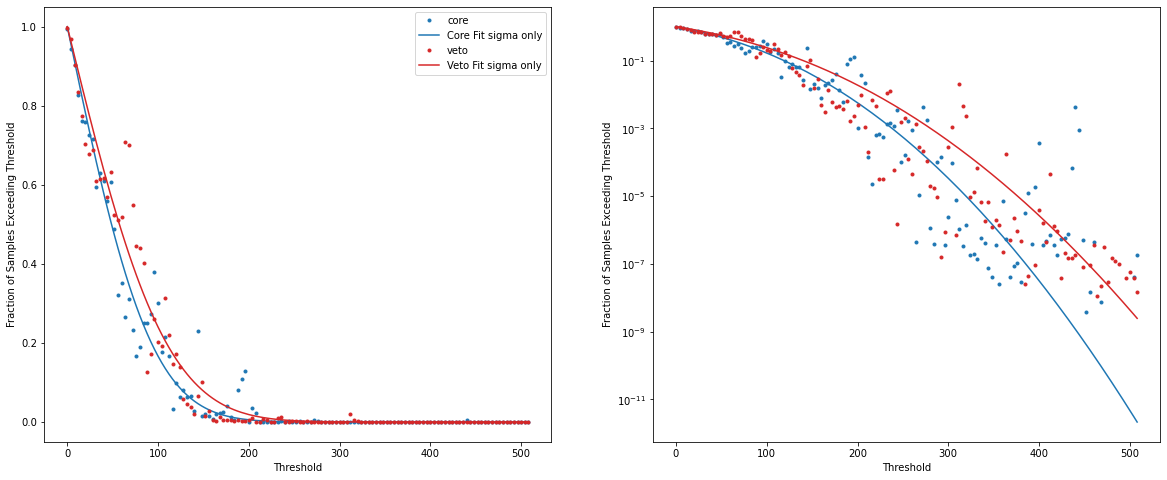

38
Fit Core
[61.48878054]
[[9.44871449]]
Fit Veto
[80.78470437]
[[8.47618758]]


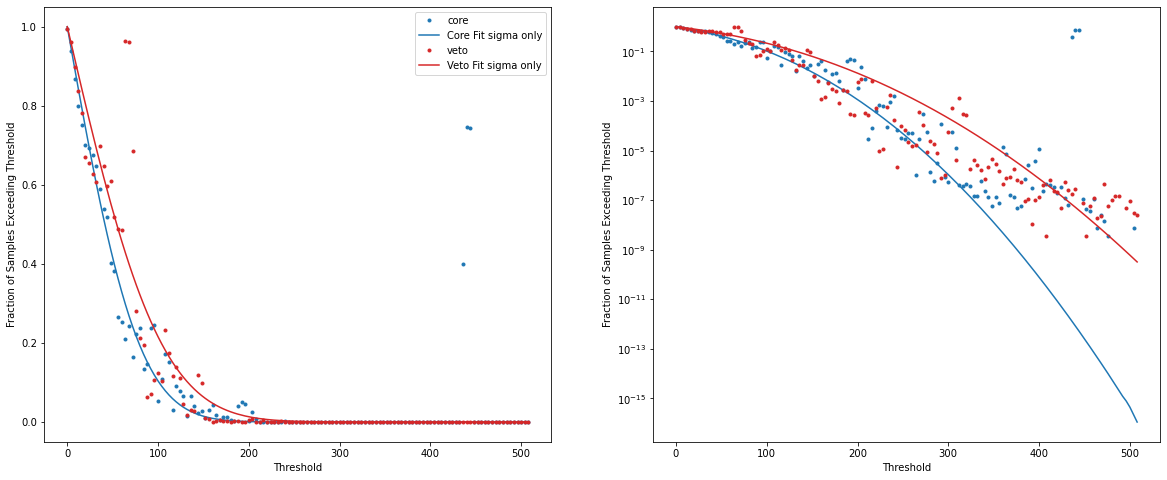

39
Fit Core
[60.51778665]
[[1.4610388]]
Fit Veto
[50.70974006]
[[2.6558444]]


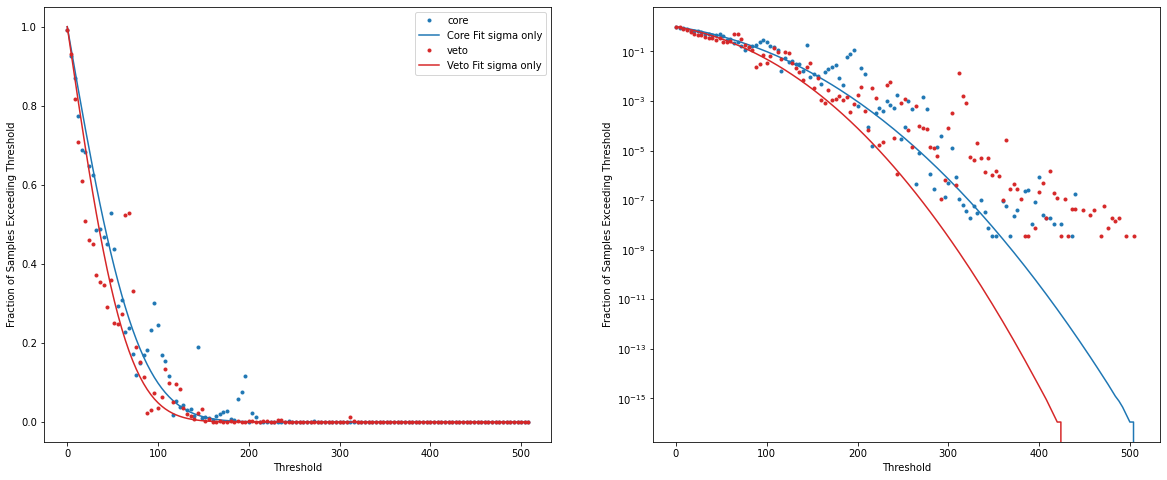

40
Fit Core
[72.02263634]
[[12.51399738]]
Fit Veto
[86.97803158]
[[8.17015492]]


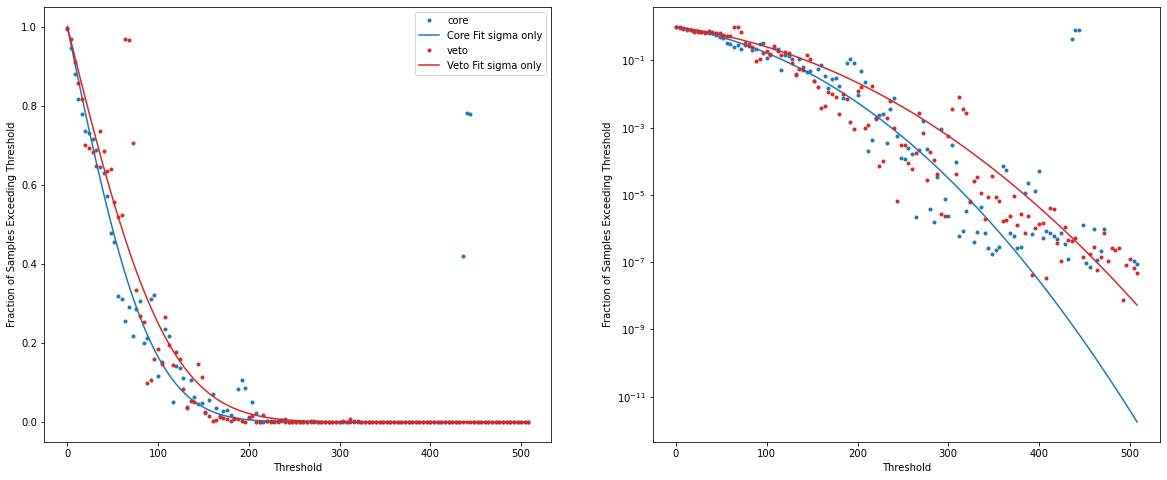

41
Fit Core
[75.13661933]
[[1.36900888]]
Fit Veto
[86.22655835]
[[3.22528187]]


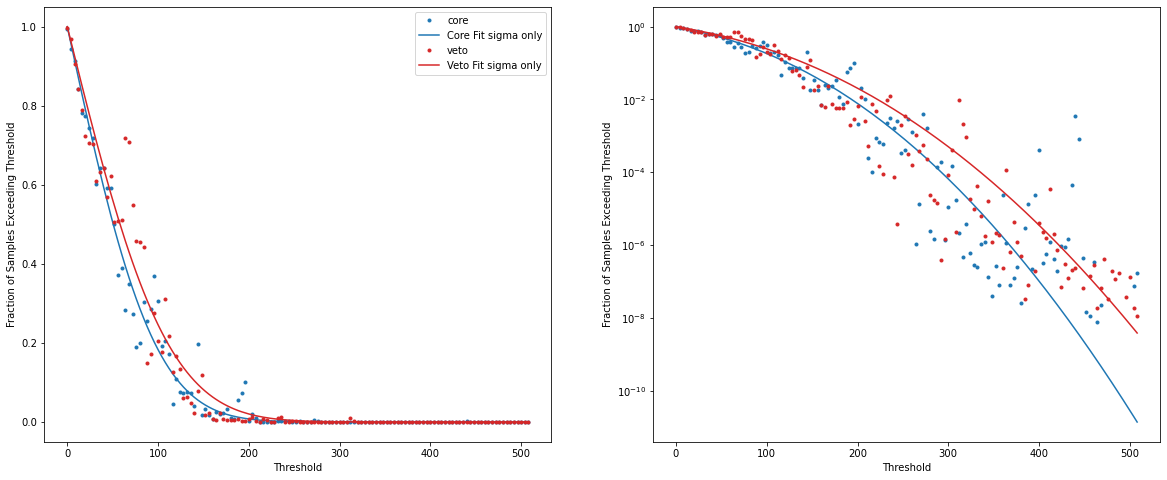

42
Fit Core
[65.04441952]
[[9.35897924]]
Fit Veto
[82.87930536]
[[8.12792593]]


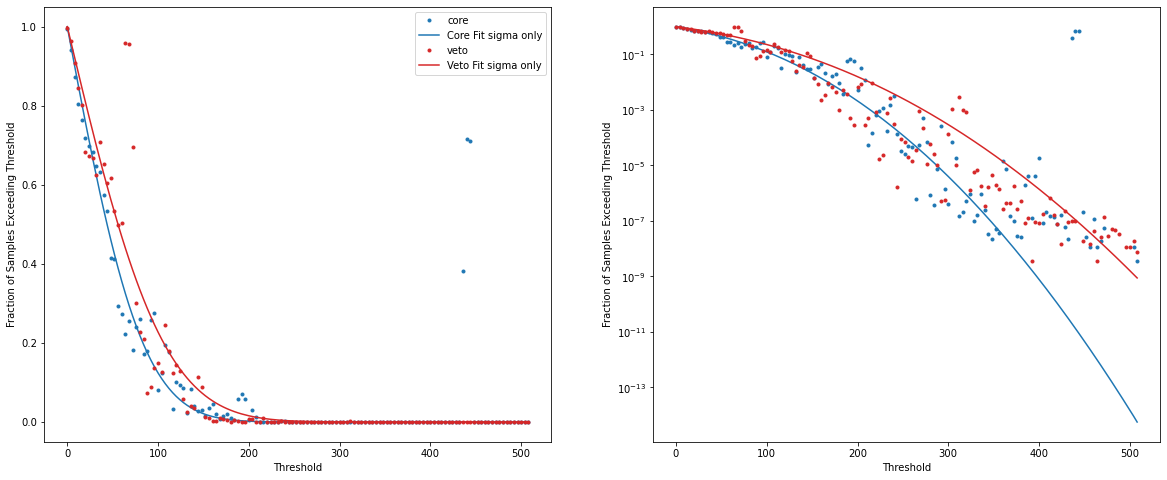

43
Fit Core
[79.07681509]
[[1.77695675]]
Fit Veto
[89.88050946]
[[4.30182027]]


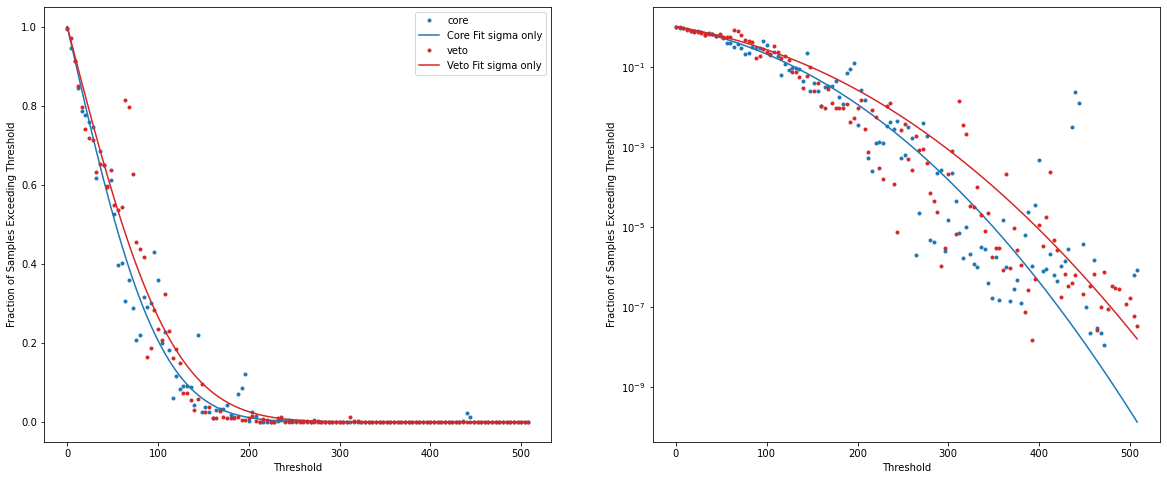

44
Fit Core
[52.96559607]
[[8.93229625]]
Fit Veto
[74.41192696]
[[8.78878999]]


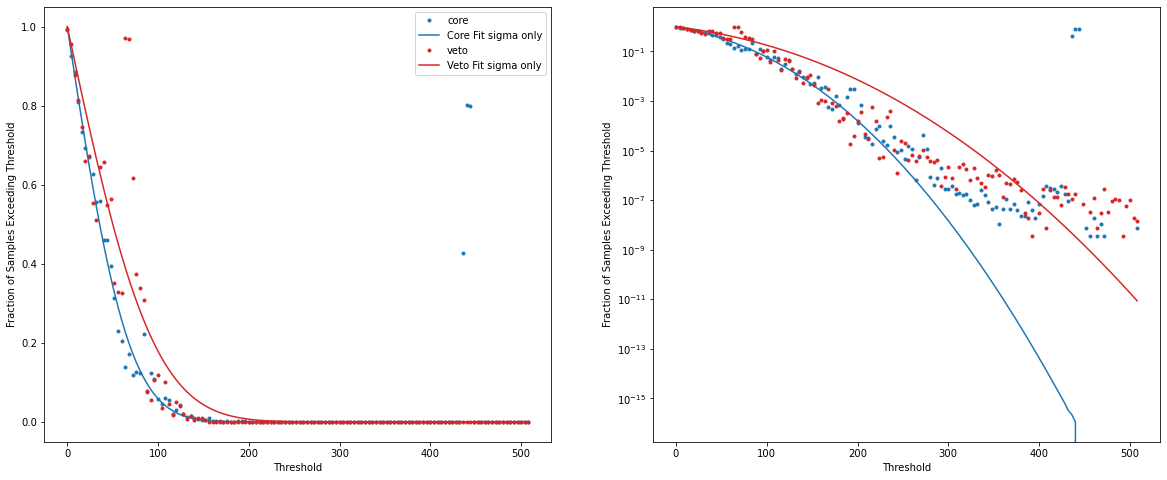

45
Fit Core
[93.26275244]
[[1.81713737]]
Fit Veto
[102.89015859]
[[5.18186347]]


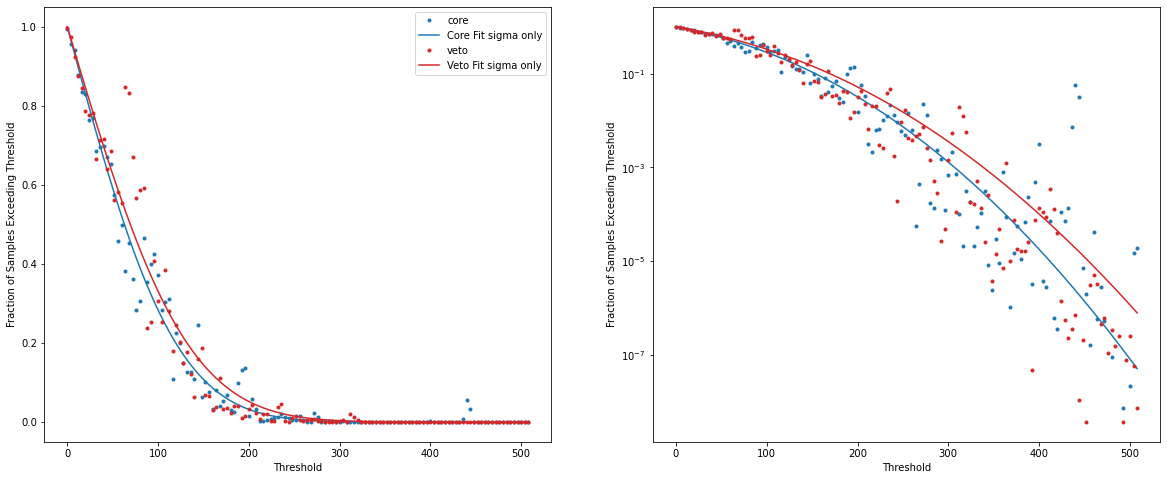

46
Fit Core
[66.71003361]
[[10.24078947]]
Fit Veto
[84.35546857]
[[8.27506647]]


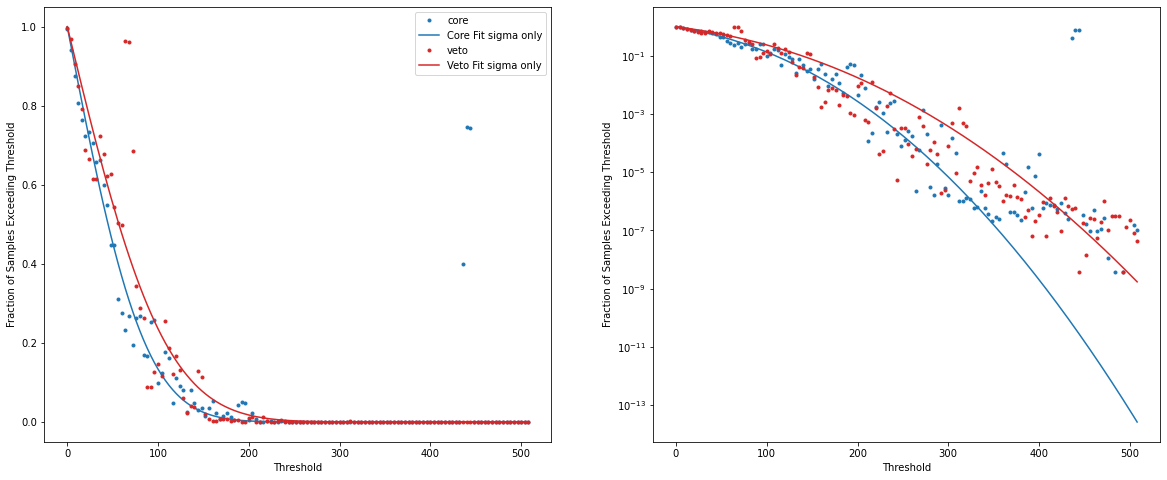

47
Fit Core
[50.26781325]
[[0.16020143]]
Fit Veto
[57.49809043]
[[1.11149178]]


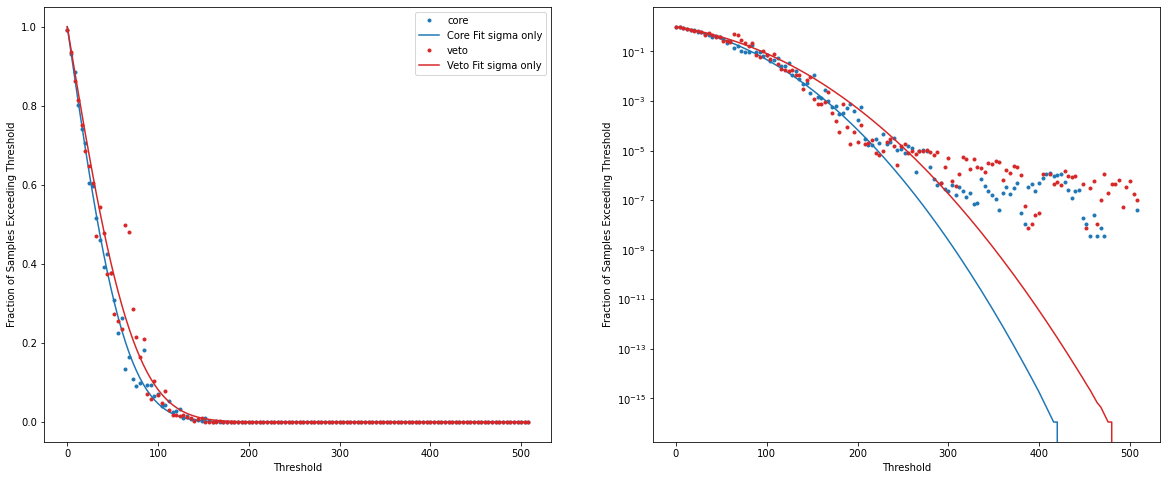

48
Fit Core
[60.15336442]
[[8.58455624]]
Fit Veto
[79.36790753]
[[8.38603457]]


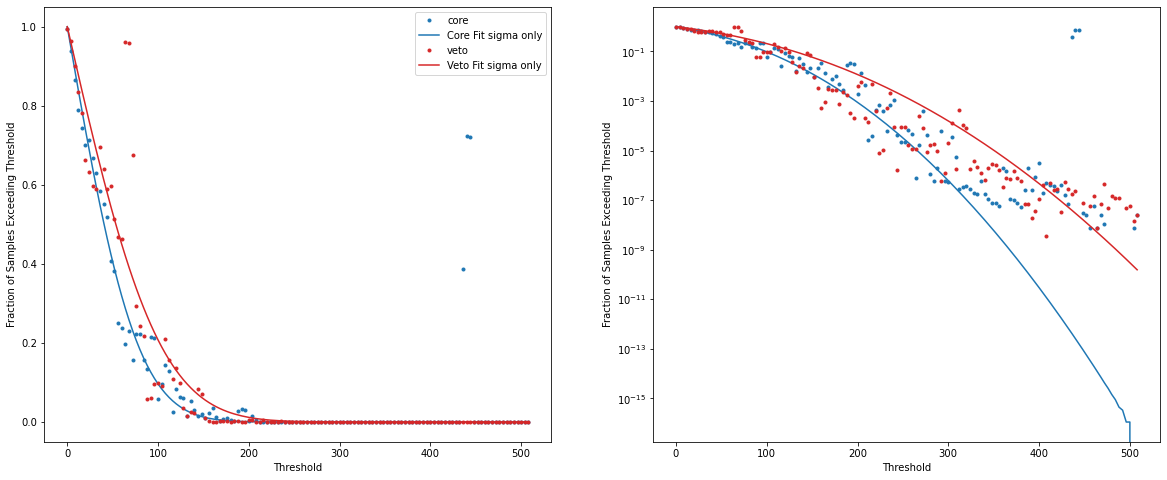

49
Fit Core
[74.77686481]
[[1.06322715]]
Fit Veto
[86.00680833]
[[2.69055497]]


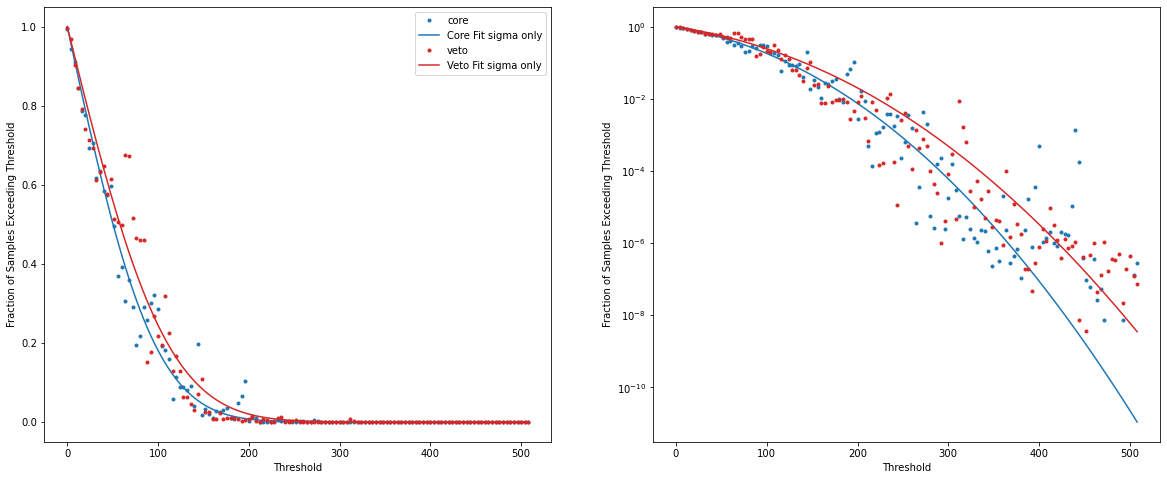

50
Fit Core
[72.8774653]
[[12.47107613]]
Fit Veto
[90.08377819]
[[8.54213624]]


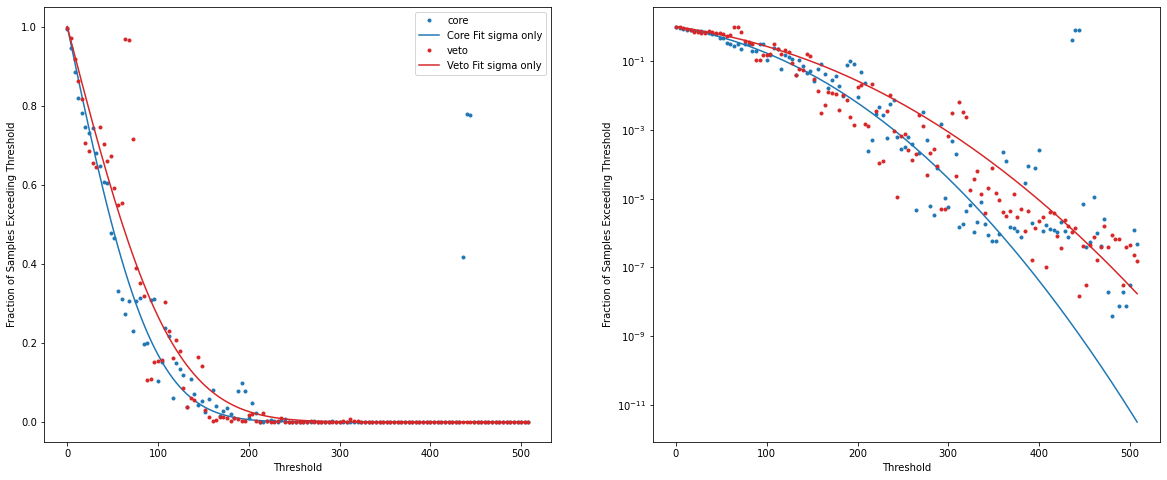

51
Fit Core
[77.02890467]
[[1.22985355]]
Fit Veto
[87.50605649]
[[2.32384132]]


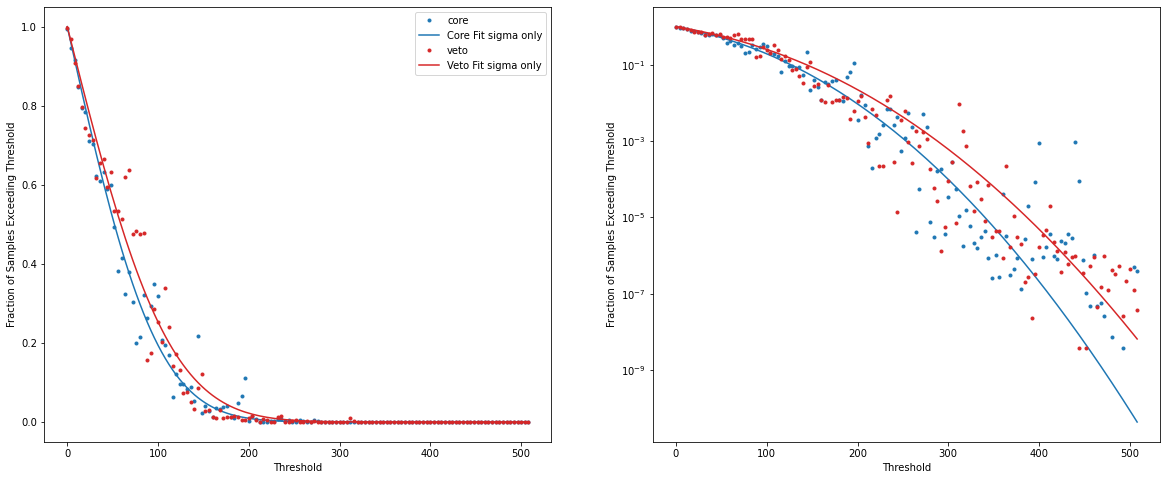

52
Fit Core
[63.92727437]
[[9.16846806]]
Fit Veto
[81.91043726]
[[8.47355952]]


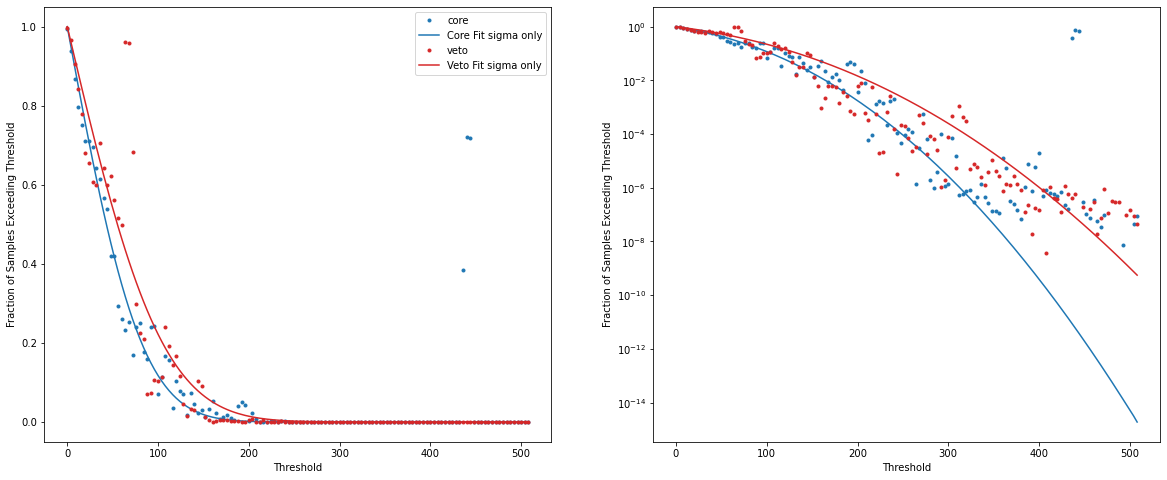

53
Fit Core
[71.65925903]
[[1.27885093]]
Fit Veto
[84.25507837]
[[3.1341937]]


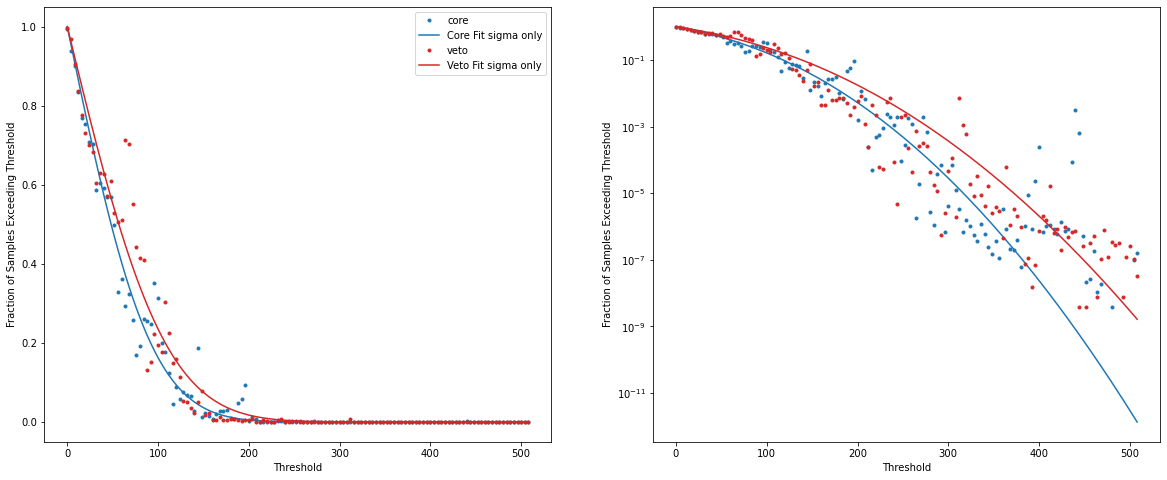

54
Fit Core
[66.06762049]
[[10.18253147]]
Fit Veto
[83.42470516]
[[8.3995399]]


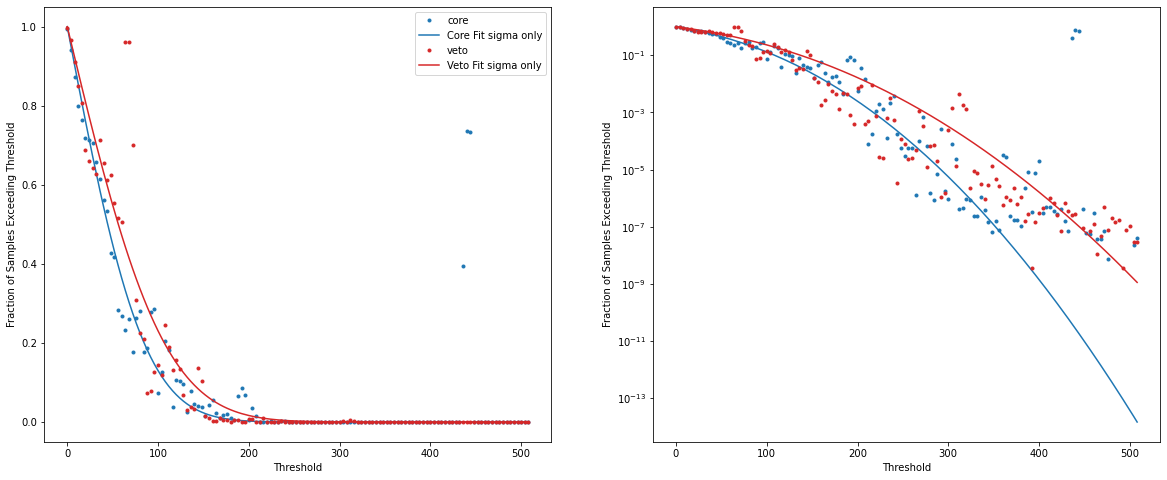

55
Fit Core
[78.22016463]
[[2.73488462]]
Fit Veto
[91.94543918]
[[4.20023681]]


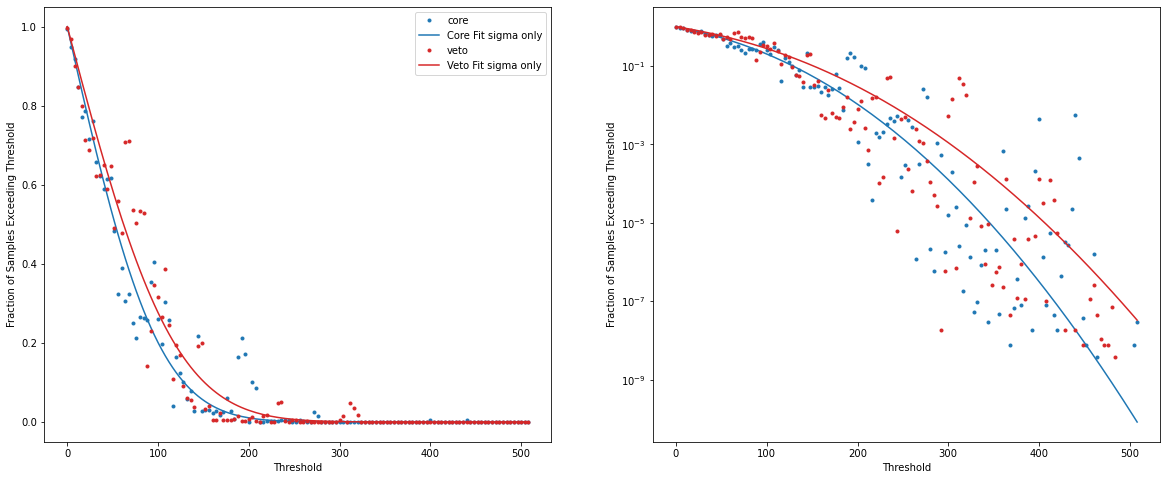

56
Fit Core
[30.85180918]
[[2.10933503]]
Fit Veto
[44.83674295]
[[8.33834671]]


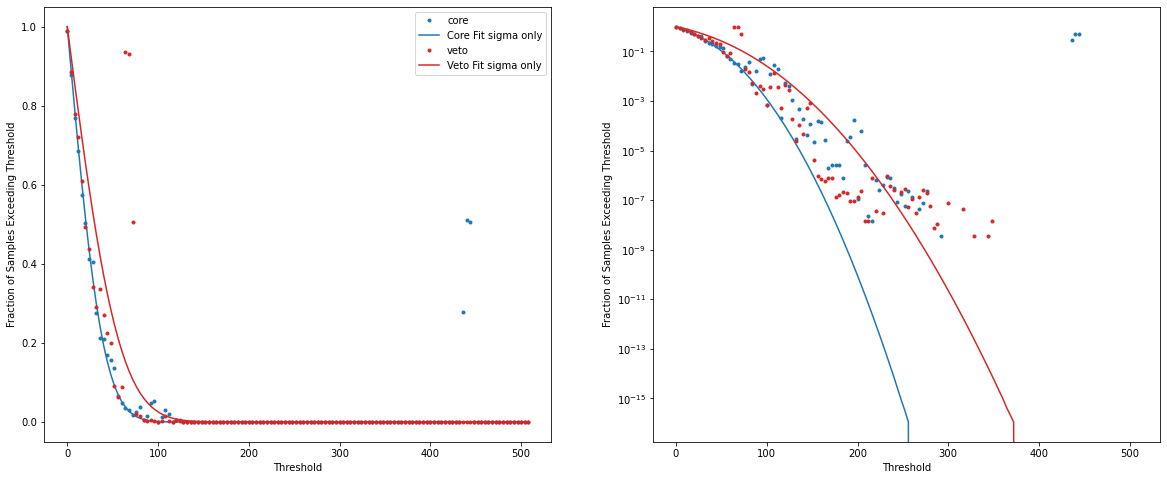

57
Fit Core
[51.89305452]
[[0.20219478]]
Fit Veto
[60.44754855]
[[3.28549981]]


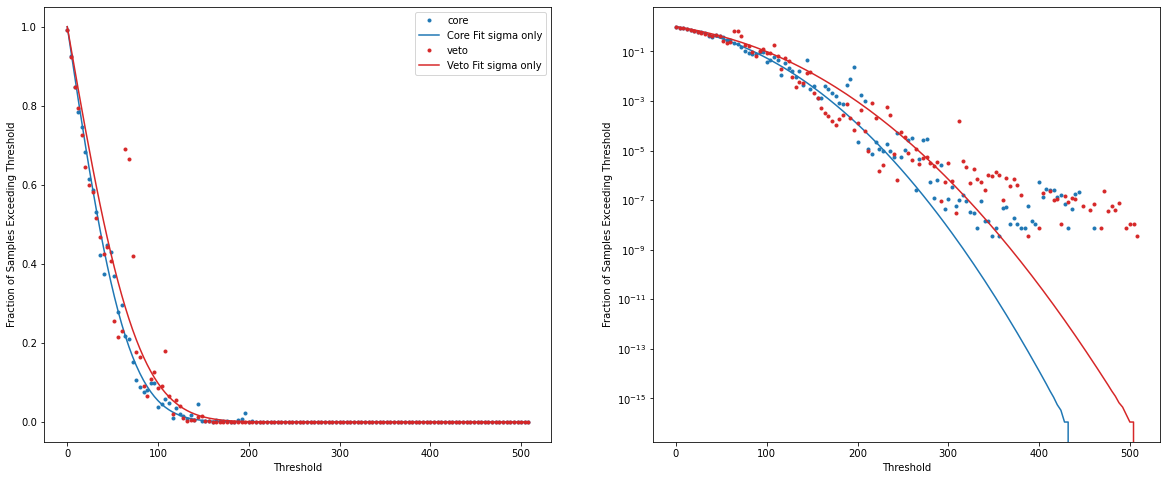

58
Fit Core
[45.12258735]
[[8.83454328]]
Fit Veto
[62.29413877]
[[8.95598709]]


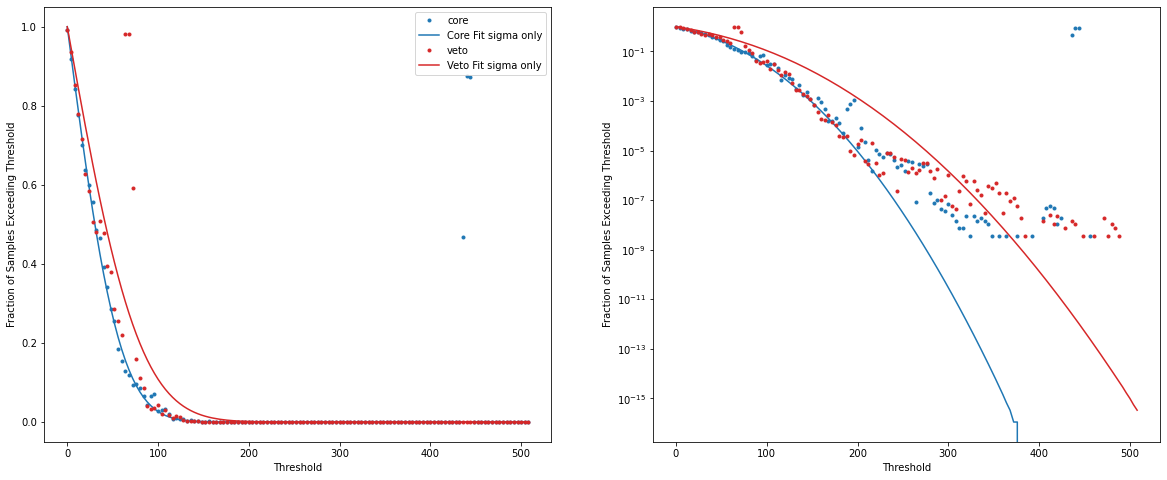

59
Fit Core
[47.48992049]
[[0.04183754]]
Fit Veto
[61.17141459]
[[6.48271126]]


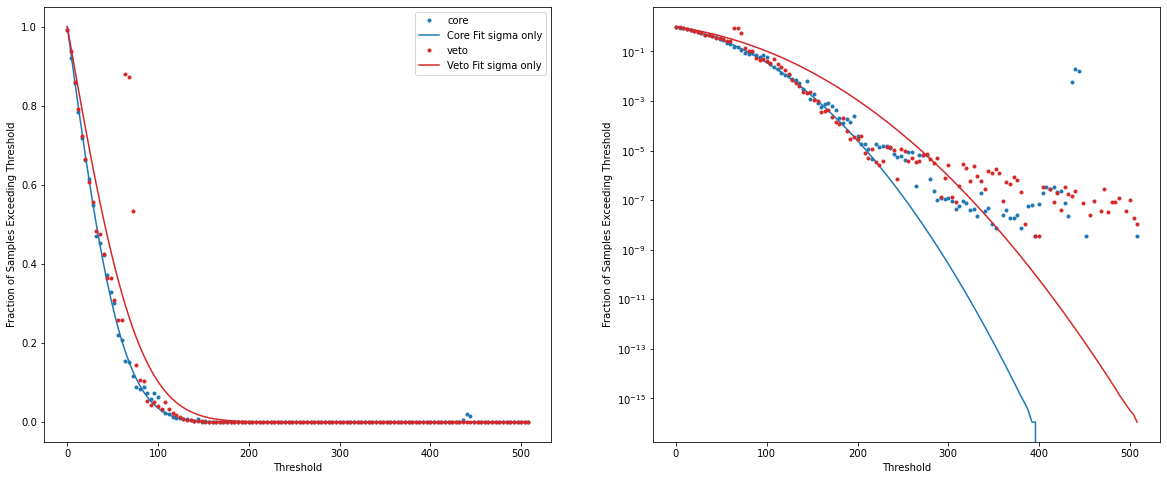

60
Fit Core
[94.96234251]
[[16.0026247]]
Fit Veto
[107.3600384]
[[7.21993474]]


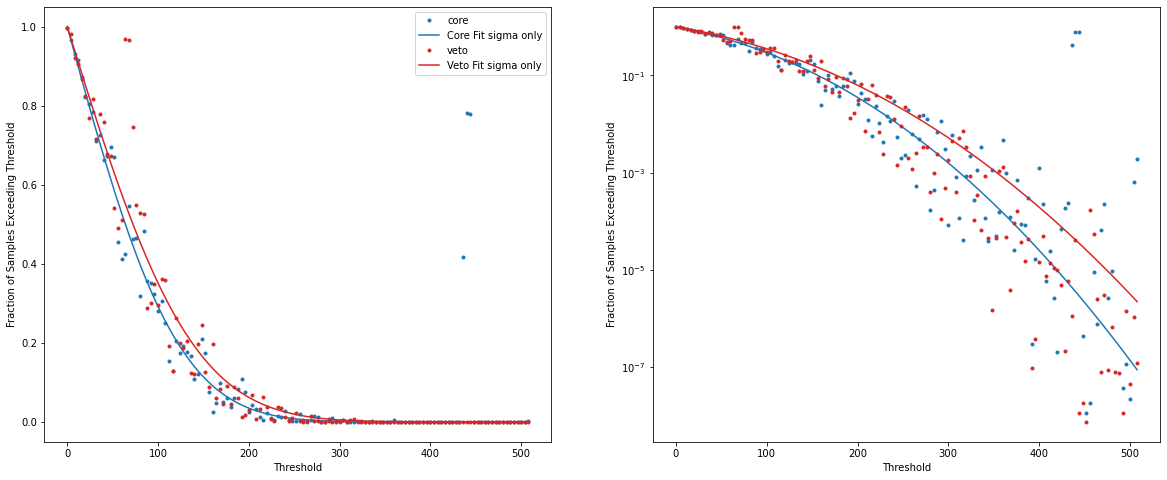

61
Fit Core
[62.59298134]
[[3.59009714]]
Fit Veto
[75.47151236]
[[7.00671473]]


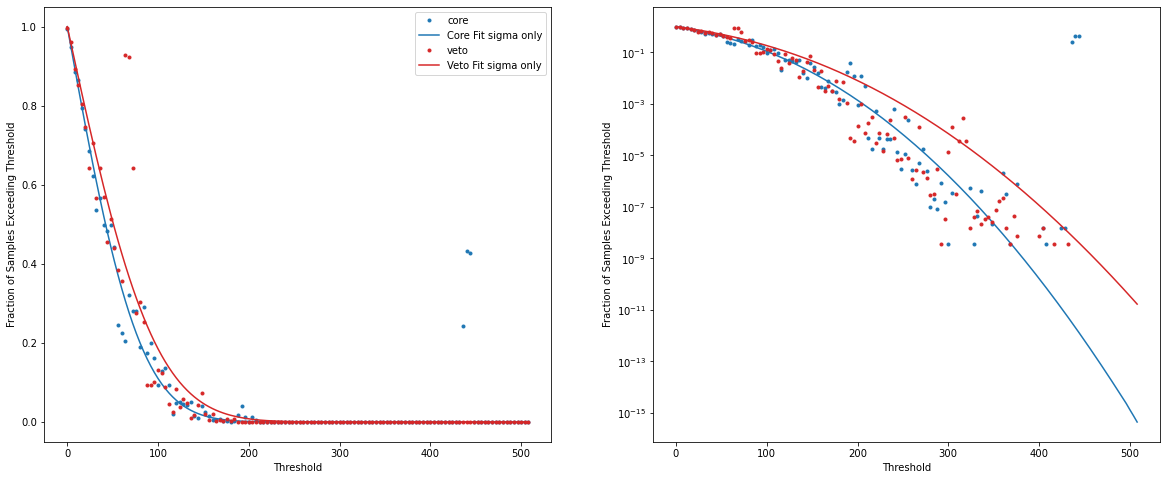

62
Fit Core
[41.89621406]
[[0.43291452]]
Fit Veto
[62.11897317]
[[7.84092381]]


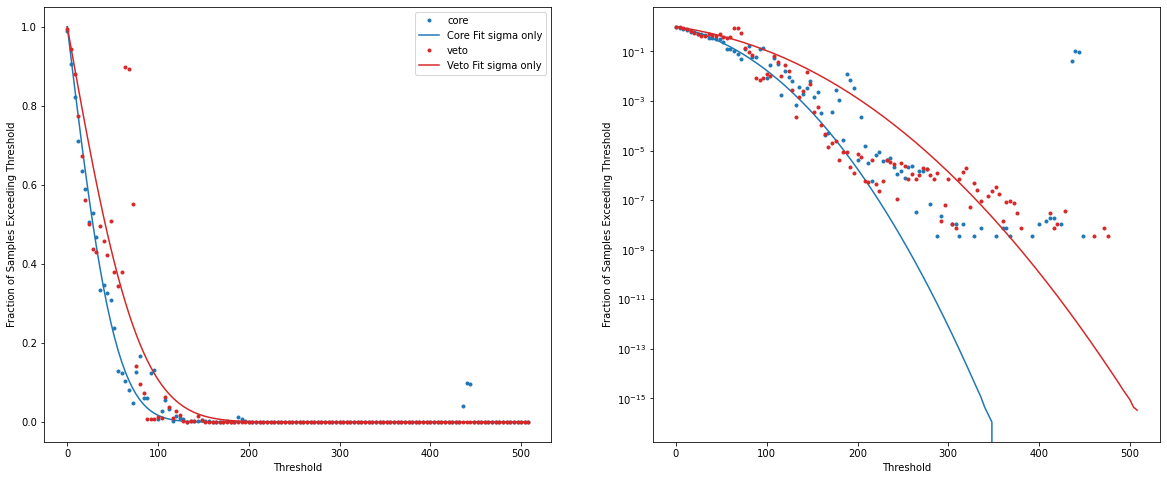

63
Fit Core
[59.54567128]
[[0.9645298]]
Fit Veto
[75.45782316]
[[2.44624877]]


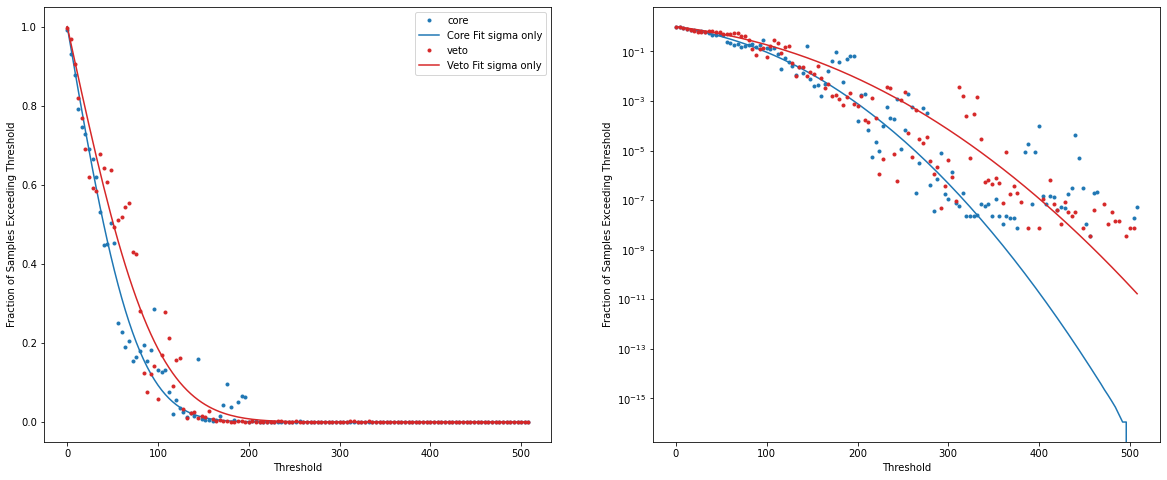

In [99]:
def prob_simple(x,s):
    #fraction of samples whose absolute value iexceeds a threshold x if the sample is described by a Gaussian PDF with zero mean and variance s^2
    p = 1 - 0.5*(sp.erf((x)/((2**0.5)*s)) + sp.erf((x)/((2**0.5)*s)))
    return p

rate_core = results_core/(2**28 - 1)
rate_veto = results_veto/(2**28 - 1)

corefitsigmas = np.zeros(64)
corefitsigmaerrs = np.zeros(64)
vetofitsigmas = np.zeros(64)
vetofitsigmaerrs = np.zeros(64)

for a in range(64):
    print(a)
    print("Fit Core")
    popt1,pcov1 = oz.curve_fit(prob_simple,thresholds,rate_core[a,:])
    corefitsigmas[a]=popt1[0]
    corefitsigmaerrs[a]=pcov1[0]
    print(popt1)
    print(pcov1)

    print("Fit Veto")
    popt2,pcov2 = oz.curve_fit(prob_simple,thresholds,np.flip(rate_veto[a,:]))
    vetofitsigmas[a]=popt2[0]
    vetofitsigmaerrs[a]=pcov2[0]
    print(popt2)
    print(pcov2)

    model1 = prob_simple(thresholds,popt1[0])
    model2 = prob_simple(thresholds,popt2[0])

    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.xlabel("Threshold")
    plt.ylabel("Fraction of Samples Exceeding Threshold")
    plt.plot(thresholds,rate_core[a,:],'C0.',label='core')
    plt.plot(thresholds,model1,'C0-',label="Core Fit sigma only")

    plt.plot(np.flip(thresholds),rate_veto[a,:],'C3.',label='veto')
    plt.plot(thresholds,model2,'C3-',label="Veto Fit sigma only")

    plt.legend()

    plt.subplot(122)
    plt.xlabel("Threshold")
    plt.ylabel("Fraction of Samples Exceeding Threshold")
    plt.semilogy(thresholds,rate_core[a,:],'C0.',label='core')
    plt.semilogy(thresholds,model1,'C0-',label="Core Fit sigma only")

    plt.semilogy(np.flip(thresholds),rate_veto[a,:],'C3.',label='veto')
    plt.semilogy(thresholds,model2,'C3-',label="Veto Fit sigma only")
    plt.show()

In [100]:
colors = ["#934b71","#48c152","#9a44bc","#78c341","#4a62d8","#abc136","#a076e9","#6b9c29","#dd70db","#389139","#c63695","#39c685","#d93668","#81be6d","#7854b1","#d0b737","#578cea","#e7a332","#5d63b4","#e58323","#3a69af","#dd6128","#54b9e5","#be2e2c","#46c6c4","#ea5749","#329981","#ea6098","#428f5c","#a24e99","#a6a83d","#c58fdb","#767c16","#e381be","#587b28","#9c9cde","#987516","#5092c9","#bd7426","#5a5f94","#c69d3f","#88609d","#357137","#b14a78","#6ebf92","#a4384a","#277257","#d56470","#78964f","#e08ea5","#586113","#e88c79","#56642b","#cd6a49","#b7b771","#96515d","#908645","#a04616","#dda573","#a45141","#755a1c","#ec945a","#89562c","#ad7947"]

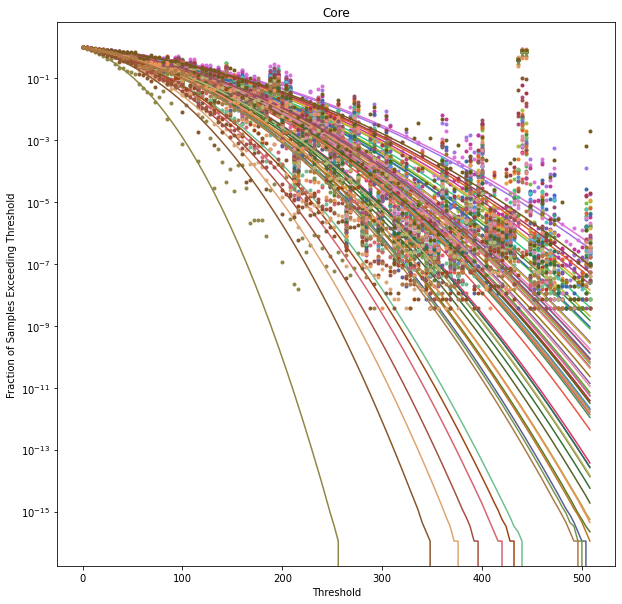

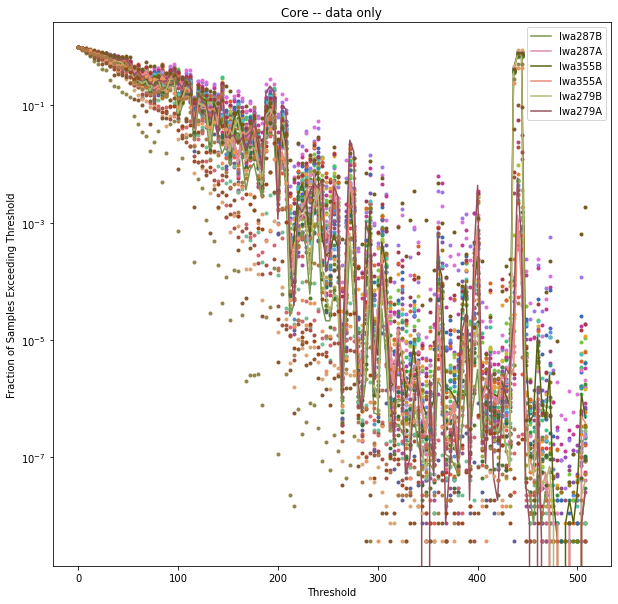

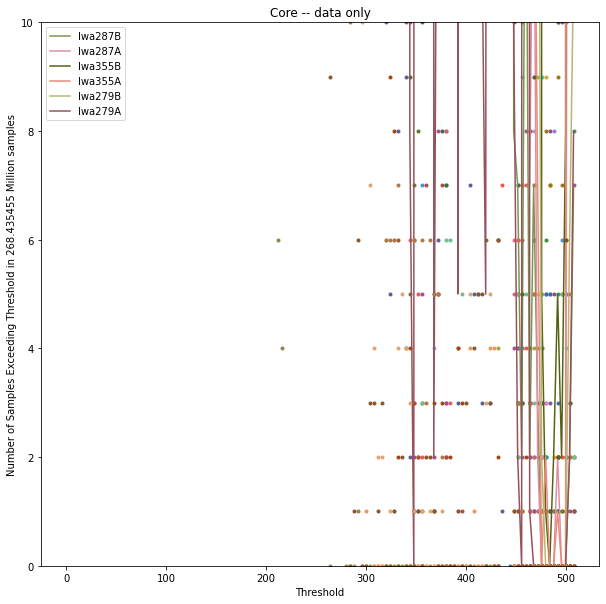

In [101]:
plt.figure(figsize=(10,10))
plt.title("Core")
for a in range(64):
    model1 = prob_simple(thresholds,corefitsigmas[a])
    plt.semilogy(thresholds,model1,color=colors[a],label="Core Fit sigma only")
    plt.semilogy(thresholds,rate_core[a,:],'.',color=colors[a],label=str(a))

plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")
#plt.legend()
plt.show()

#semilog with veto antennas highlighted
fig=plt.figure(figsize=(10,10))
plt.title("Core -- data only")
for a in range(64):
    model1 = prob_simple(thresholds,corefitsigmas[a])

    if int(chanmap[1,a])==60:
        plt.semilogy(thresholds,rate_core[a,:],color=colors[a],label=str('lwa355A'))

    elif int(chanmap[1,a])==61:
        plt.semilogy(thresholds,rate_core[a,:],color=colors[a],label=str('lwa355B'))

    elif int(chanmap[1,a])==62:
        plt.semilogy(thresholds,rate_core[a,:],color=colors[a],label=str('lwa287A'))

    elif int(chanmap[1,a])==63:
        plt.semilogy(thresholds,rate_core[a,:],color=colors[a],label=str('lwa287B'))

    elif int(chanmap[1,a])==56:
        plt.semilogy(thresholds,rate_core[a,:],color=colors[a],label=str('lwa279A'))

    elif int(chanmap[1,a])==57:
        plt.semilogy(thresholds,rate_core[a,:],color=colors[a],label=str('lwa279B'))
    else:
        plt.semilogy(thresholds,rate_core[a,:],'.',color=colors[a])

plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")
plt.legend()
plt.show()

#linear scale, zoomed on tails
fig=plt.figure(figsize=(10,10))
plt.title("Core -- data only")
for a in range(64):
    model1 = prob_simple(thresholds,corefitsigmas[a])

    if int(chanmap[1,a])==60:
        plt.plot(thresholds,results_core[a,:],color=colors[a],label=str('lwa355A'))

    elif int(chanmap[1,a])==61:
        plt.plot(thresholds,results_core[a,:],color=colors[a],label=str('lwa355B'))

    elif int(chanmap[1,a])==62:
        plt.plot(thresholds,results_core[a,:],color=colors[a],label=str('lwa287A'))

    elif int(chanmap[1,a])==63:
        plt.plot(thresholds,results_core[a,:],color=colors[a],label=str('lwa287B'))

    elif int(chanmap[1,a])==56:
        plt.plot(thresholds,results_core[a,:],color=colors[a],label=str('lwa279A'))

    elif int(chanmap[1,a])==57:
        plt.plot(thresholds,results_core[a,:],color=colors[a],label=str('lwa279B'))
    else:
        plt.plot(thresholds,results_core[a,:],'.',color=colors[a])

plt.xlabel("Threshold")
plt.ylabel("Number of Samples Exceeding Threshold in 268.435455 Million samples")
plt.ylim((0,10))
plt.legend()
plt.show()

# How often are antennas saturating?

508
LWA-110A 2897.0
LWA-107A 1761.0
LWA-108B 4965.0
LWA-081A 1147.0
LWA-117A 3167.0
LWA-115B 1091.0
LWA-115A 1690.0
LWA-082A 5075.0
LWA-148B 506260.0
57


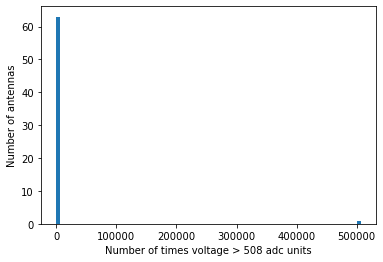

In [108]:
# how often is saturation?
plt.figure()
plt.hist(results_core[:,-1],80)
plt.xlabel("Number of times voltage > 508 adc units")
plt.ylabel("Number of antennas")

print(thresholds[-1])
count=0
for a in range(64):
    if results_core[a,-1]>1000:
        fpgachan=channelmap[1,a]
        antname=mapping.snap2_to_antpol(7,fpgachan)
        print(antname, results_core[a,-1])
        
    if results_core[a,-1]>=1:
        count+=1
print(count)



# Single Board Threshold Scan, no veto
For this test, all the antennas are trigger antennas.

In [109]:
setvalue(casperbrd,'eth_enable','cr_registers.xlsx',0)


In [110]:
def packantennaroles(roles_array):
    #turn an array of 64 ones and zeros into two 32 bit integers, one for the first half and one for the second
    output1=0
    output2=0
    for i in range(32):
        output1+=roles_array[i]<<i
        output2+=roles_array[i+32]<<i

    return output1, output2

In [111]:
core_roles_array=np.ones(64,dtype=int)
core_roles1,core_roles2=packantennaroles(core_roles_array)
print(core_roles1,core_roles2)
#set the antenna roles
setvalue(casperbrd,'trigger_antennas1','cr_registers.xlsx',core_roles1)
setvalue(casperbrd,'trigger_antennas2','cr_registers.xlsx',core_roles2)
setvalue(casperbrd,'veto_antennas1','cr_registers.xlsx',0)
setvalue(casperbrd,'veto_antennas2','cr_registers.xlsx',0)
setvalue(casperbrd,'trigger_window','cr_registers.xlsx',int(round(1.97e8*100/3e8,1))) #number of clock cycles to travel 100 meters
setvalue(casperbrd,'veto_window','cr_registers.xlsx',0) #not using for now
setvalue(casperbrd,'antenna_number_thresh','cr_registers.xlsx',5) 
setvalue(casperbrd,'veto_number_thresh','cr_registers.xlsx',0) #not using for now



4294967295 4294967295


In [121]:
voltage_thresh=np.asarray([50,100,150,200,225,250,270,300,350,400,450,500,512])
ant_number_thresh=np.asarray([4,5,6,7])
core_coincidences=np.zeros((len(voltage_thresh),len(ant_number_thresh)))
for m in range(len(ant_number_thresh)):
    setvalue(casperbrd,'antenna_number_thresh','cr_registers.xlsx',ant_number_thresh[m]) 
    for i in range(len(voltage_thresh)):
        t_c = voltage_thresh[i]
        setvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(t_c**2))
        time.sleep(2.75)  #have to wait for it to update
        veto_coincidence,core_coincidence=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))
        core_coincidences[i,m]=core_coincidence

In [122]:
core_coincidences[7,3]
core_coincidences.shape
print(voltage_thresh)

[ 50 100 150 200 225 250 270 300 350 400 450 500 512]


Text(0, 0.5, 'number of coincidences')

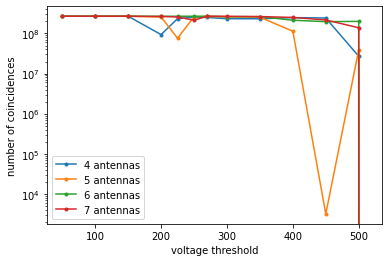

In [125]:
for m in range(len(ant_number_thresh)):
    plt.semilogy(voltage_thresh,core_coincidences[:,m],'.-',label=str(ant_number_thresh[m])+ ' antennas')
plt.legend()
plt.xlabel('voltage threshold')
plt.ylabel('number of coincidences')

In [369]:
#attempt to get trigger to readout working failed because somewhere the coincidence trigger signal is blocked
#setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",1)
#setvalue(casperbrd,'antenna_number_thresh','cr_registers.xlsx',2) 
#setvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(2**2))


In [370]:
getvalue(casperbrd,"count_triggers","cr_registers.xlsx")
#reset the trigger counter

17

# Window length scan with long baselines
I'm using the core coincidence counting even though these will eventually be veto antennas, because the veto counter is counting from the wrong place.

I think these antennas did not have delays to set, so interpreting this plot is still not very useful.

Text(0, 0.5, ' Proxy for Number of coincidences')

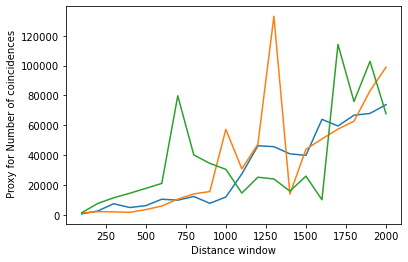

In [126]:
core_roles_array=np.zeros(64,dtype=int)
core_roles_array[60]=1 #355A
core_roles_array[61]=1 #355B
core_roles_array[62]=1 #287A
core_roles_array[63]=1 #287B
core_roles1,core_roles2=packantennaroles(core_roles_array)

setvalue(casperbrd,'trigger_antennas1','cr_registers.xlsx',core_roles1)
setvalue(casperbrd,'trigger_antennas2','cr_registers.xlsx',core_roles2)
setvalue(casperbrd,'veto_antennas1','cr_registers.xlsx',0)
setvalue(casperbrd,'veto_antennas2','cr_registers.xlsx',0)
setvalue(casperbrd,'veto_window','cr_registers.xlsx',0) #not using for now
setvalue(casperbrd,'antenna_number_thresh','cr_registers.xlsx',3) #require both polarizations of one antenna and at least one of the other
setvalue(casperbrd,'veto_number_thresh','cr_registers.xlsx',0) #not using for now
setvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(300**2))

for i in range(3):
    distances=100*np.asarray([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
    coincidences=np.zeros(len(distances))
    for d in range(len(distances)):
        w=int(round(1.97e8*distances[d]/3e8,1))
        setvalue(casperbrd,'trigger_window','cr_registers.xlsx',w) #number of clock cycles to travel 100 meters
        time.sleep(2.75)
        veto_coincidence,core_coincidence=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))
        coincidences[d]=core_coincidence  #have to divide by window length because it's counting the total overlap
    plt.plot(distances,coincidences)
plt.xlabel("Distance window")
plt.ylabel(" Proxy for Number of coincidences")

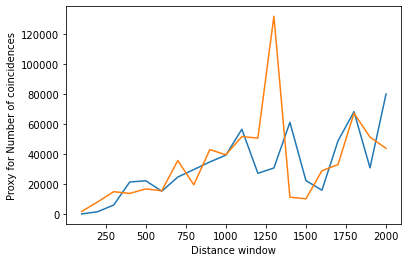

In [127]:
#three antennas

core_roles_array=np.zeros(64,dtype=int)
core_roles_array[60]=1 #355A
core_roles_array[61]=1 #355B
core_roles_array[62]=1 #287A
core_roles_array[63]=1 #287B
core_roles_array[56]=1 #279A
core_roles_array[57]=1 #279B

core_roles1,core_roles2=packantennaroles(core_roles_array)

setvalue(casperbrd,'trigger_antennas1','cr_registers.xlsx',core_roles1)
setvalue(casperbrd,'trigger_antennas2','cr_registers.xlsx',core_roles2)
setvalue(casperbrd,'veto_antennas1','cr_registers.xlsx',0)
setvalue(casperbrd,'veto_antennas2','cr_registers.xlsx',0)
setvalue(casperbrd,'veto_window','cr_registers.xlsx',0) #not using for now
setvalue(casperbrd,'antenna_number_thresh','cr_registers.xlsx',4) #require both polarizations of two antennas OR at least one of all three
setvalue(casperbrd,'veto_number_thresh','cr_registers.xlsx',0) #not using for now
setvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(300**2))


plt.xlabel("Distance window")
plt.ylabel("Proxy for Number of coincidences")
for i in range(2):
    time.sleep(2.75)

    distances=100*np.asarray([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
    coincidences=np.zeros(len(distances))
    for d in range(len(distances)):
        w=int(round(1.97e8*distances[d]/3e8,1))
        setvalue(casperbrd,'trigger_window','cr_registers.xlsx',w) #number of clock cycles to travel 100 meters
        time.sleep(2.75)
        veto_coincidence,core_coincidence=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))
        coincidences[d]=core_coincidence  #have to divide by window length because it's counting the total overlap
    plt.plot(distances,coincidences)


In [403]:
veto_coincidence,core_coincidence=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))


# Single Board Threshold Scan, with veto

# Scratchwork